## Python project for analyzing and developing different buying strategies 

In [1]:
import json
from coin_data import get_coin_data, plot_actions, plot_profit
from agents.investors.simple_stop_loss import SimpleStopLossInvestor

In [2]:
json_file_path = "config.json"

# Open and read the JSON file
with open(json_file_path, "r") as json_file:
    config = json.load(json_file)

# print config file
for property, property_info in config.items():
    print(property, ":", property_info["description"])
print("")

# print config properties values
coin = config["coin"]["value"]
print("coin:", coin)

interval = config["interval"]["value"]
print("interval:", interval)

# period = config["period"]["value"]
# print("period:", period)

portfolio_size = config["portfolio_size"]["value"]
print("portfolio_size:", portfolio_size)

coin : An uppercase string code representation of a particular trading pair or instrument. This is usually written as BaseCurrency/QuoteCurrency with a slash as in BTC/USD, LTC/CNY or ETH/EUR, etc. Symbols are used to reference markets within the ccxt library.
interval : Interval between each ticker data point.
period : Period of time that specifies the time interval to be used when fetching data: [period, currentTime]. Possible values are: [d, mo, y, max]
portfolio_size : Initial amount of money (USD) to be used by the trading agent.
DCA_interval : Interval between each DCA (Dollar Cost Averaging) investment (as value * ticker intervals).
BB_window : Window size for the Bollinger Bands indicator.
BB_std : Standard deviation for the Bollinger Bands indicator.

coin: BTC/USDT
interval: 1h
portfolio_size: 2000


In [3]:
# get coin data
# TODO: get coin data from start date to end date (aggregate data)
# TODO: add sentiment analysis API data
coin_data = get_coin_data(coin, interval)

coin_data

,Open,High,Low,Close,Volume
Timestamp,,,,,
2023-11-05 03:00:00,35049.73,35300.00,35016.09,35277.01,1362.57865
2023-11-05 04:00:00,35277.02,35305.75,35122.53,35151.11,1330.76132
2023-11-05 05:00:00,35151.11,35229.42,35117.55,35163.98,724.25247
2023-11-05 06:00:00,35163.99,35171.68,35043.92,35057.28,764.13102
2023-11-05 07:00:00,35057.28,35180.00,35044.23,35162.46,710.60772
...,...,...,...,...,...
2023-11-25 18:00:00,37765.37,37820.00,37756.24,37815.63,450.92125
2023-11-25 19:00:00,37815.63,37835.39,37790.10,37819.43,381.86056
2023-11-25 20:00:00,37819.43,37888.00,37763.84,37788.99,763.33330


In [4]:
type(coin_data.index[0])

pandas._libs.tslibs.timestamps.Timestamp

DCA_interval: 7
dca_investment_amount: 27.77777777777778


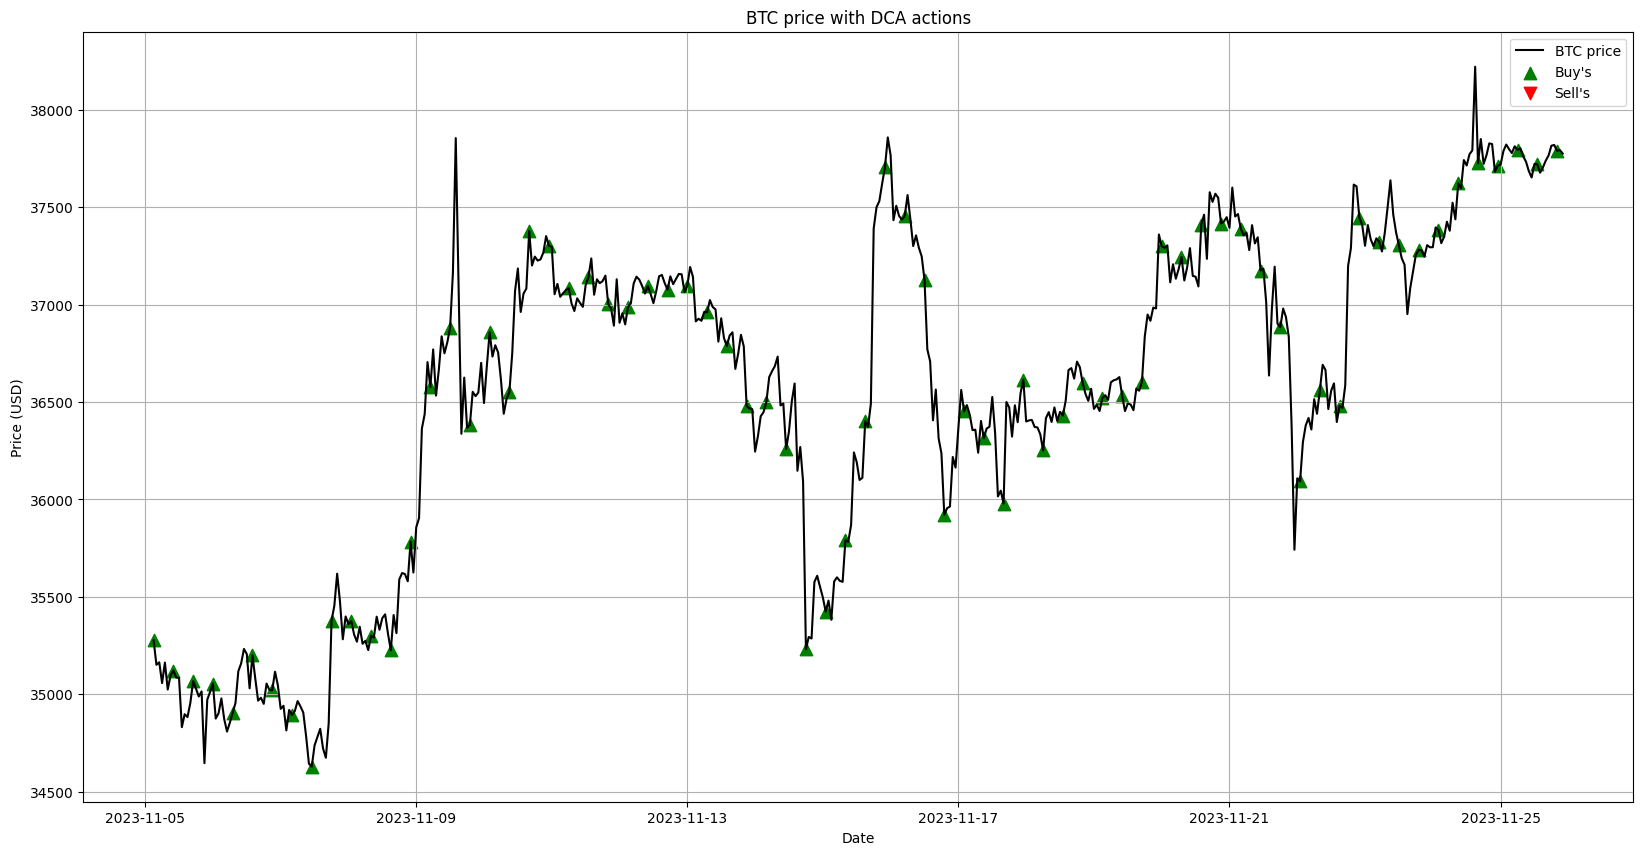

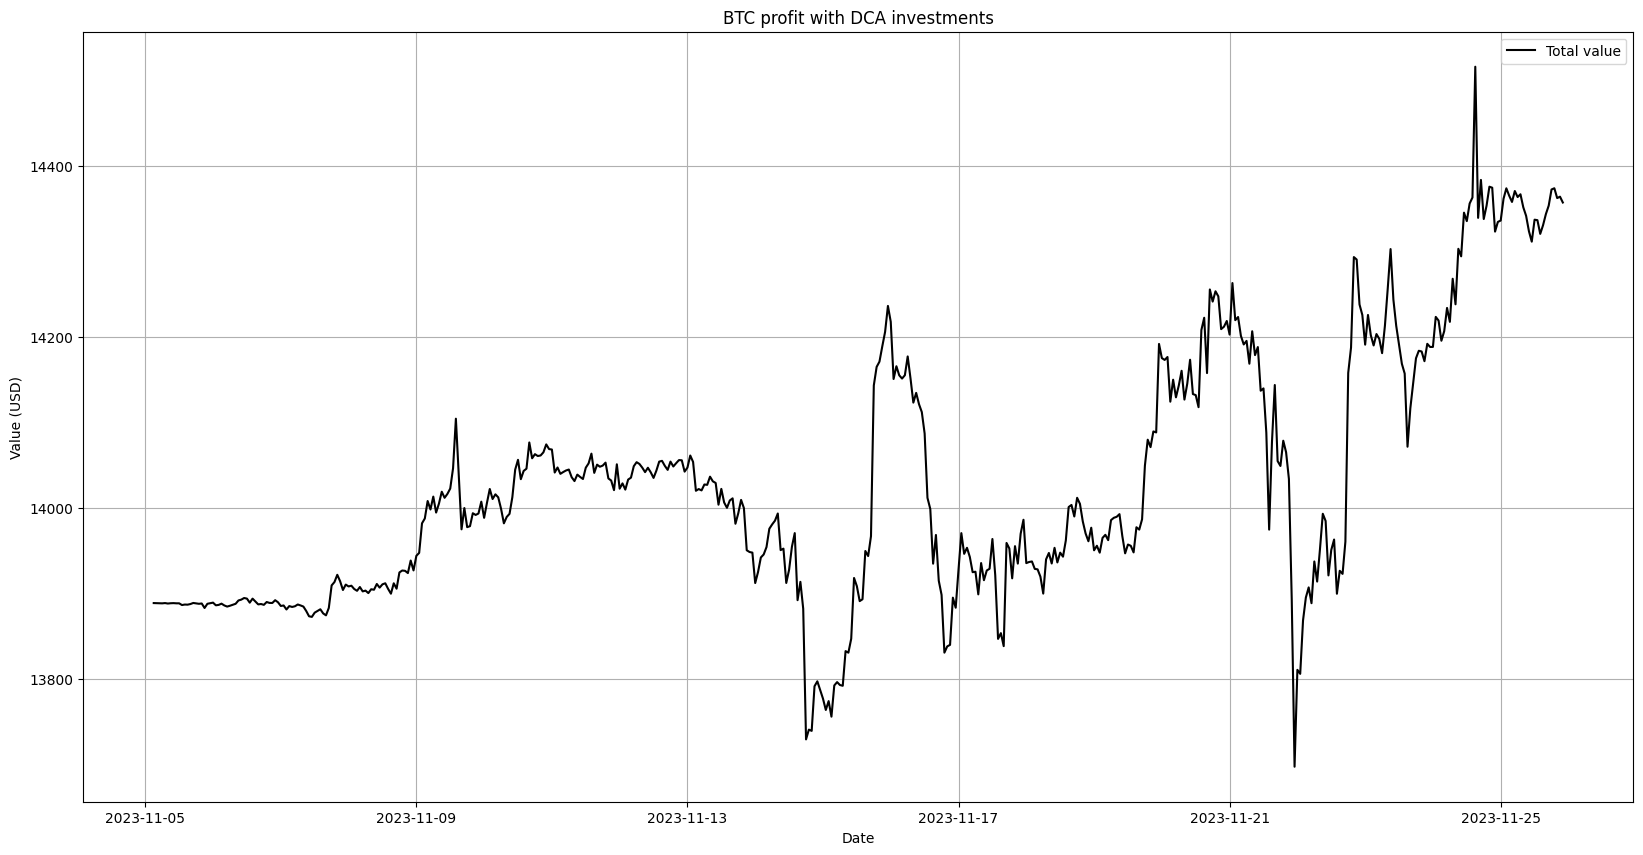

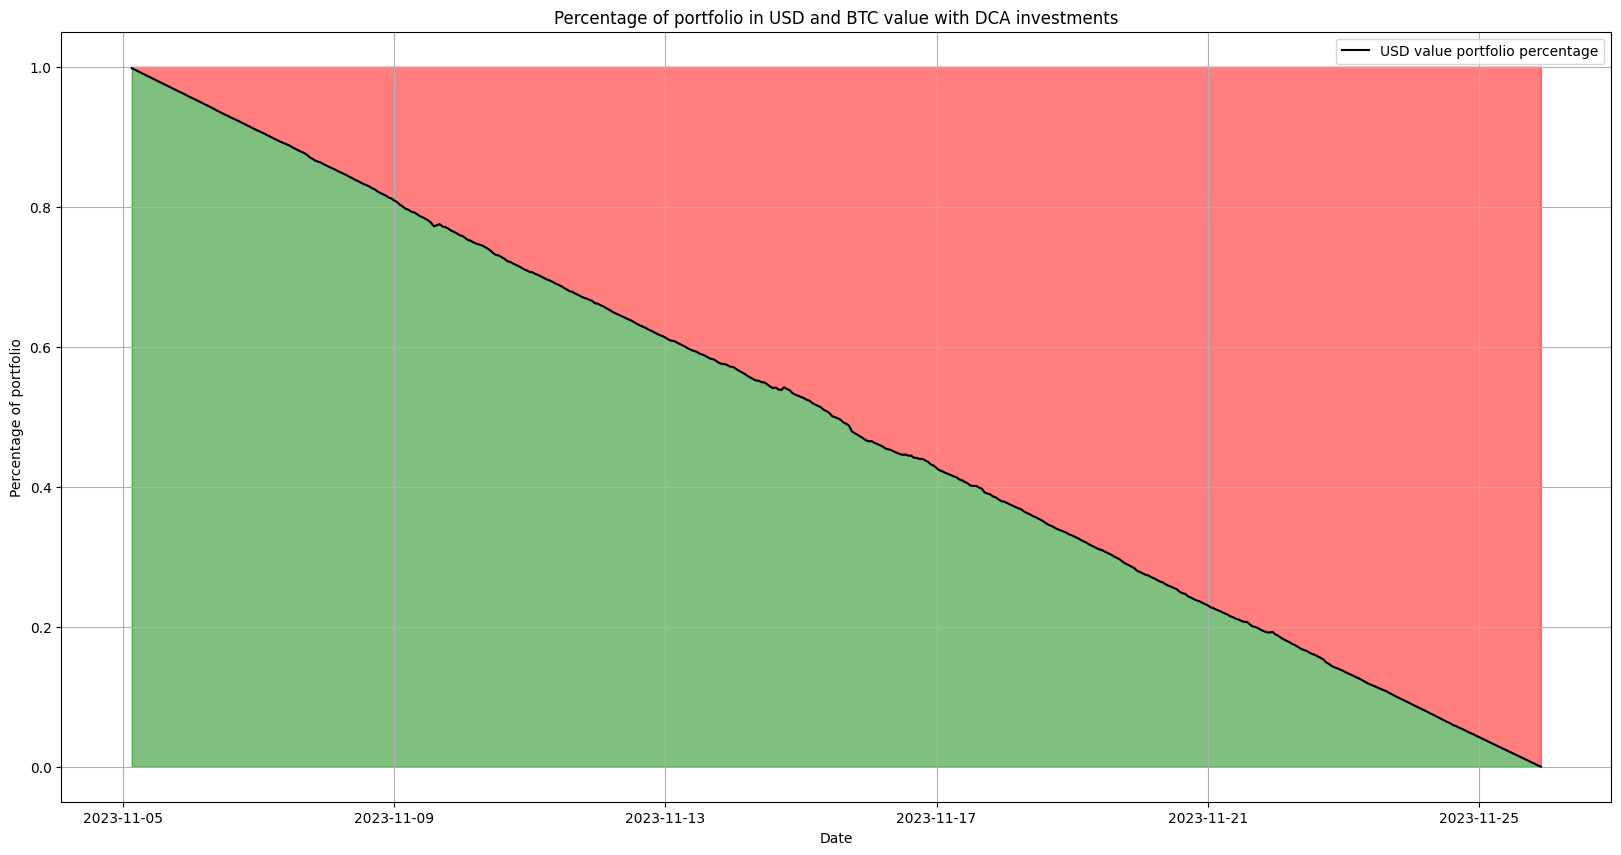

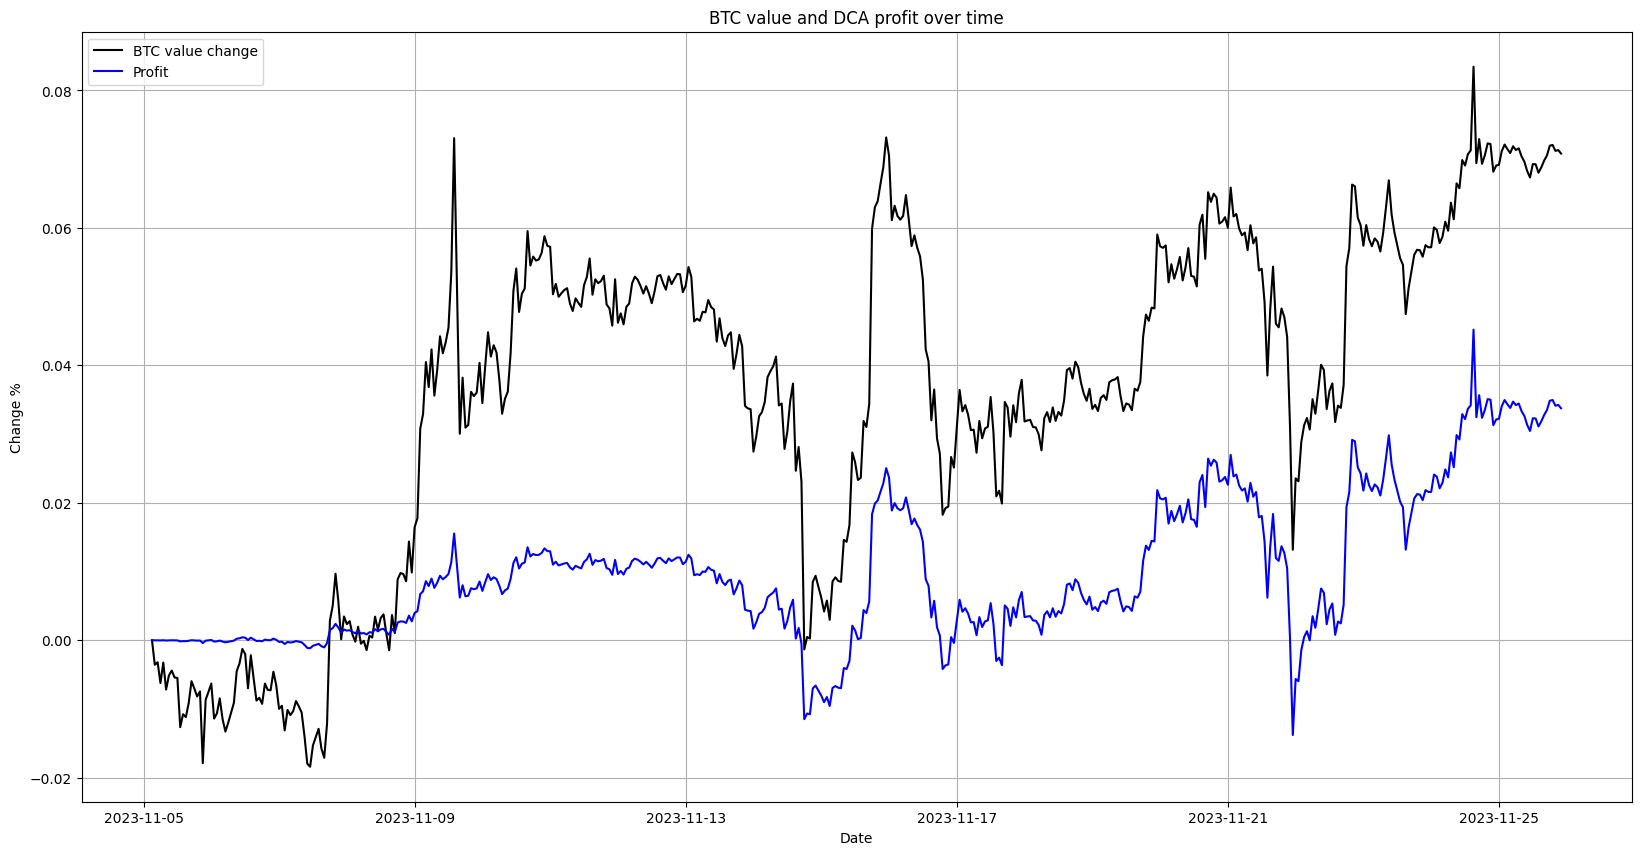

In [5]:
# use DCA as baseline agent
from agents.basic.dollar_cost_averaging import DcaAgent
from math import ceil

dca_interval = config["DCA_interval"]["value"]
dca_investment_amount = portfolio_size / ceil(len(coin_data) / dca_interval)

print("DCA_interval:", dca_interval)
print("dca_investment_amount:", dca_investment_amount)

dca_agent = DcaAgent(dca_interval, dca_investment_amount)

dca_actions = dca_agent.act(coin_data)
dca_investment = dca_agent.get_investments(coin_data)

# plot DCA actions
plot_actions(coin_data, dca_actions, "BTC", "DCA")
plot_profit(coin_data, dca_investment, "BTC", "DCA")

bb_window: 20
bb_std: 2


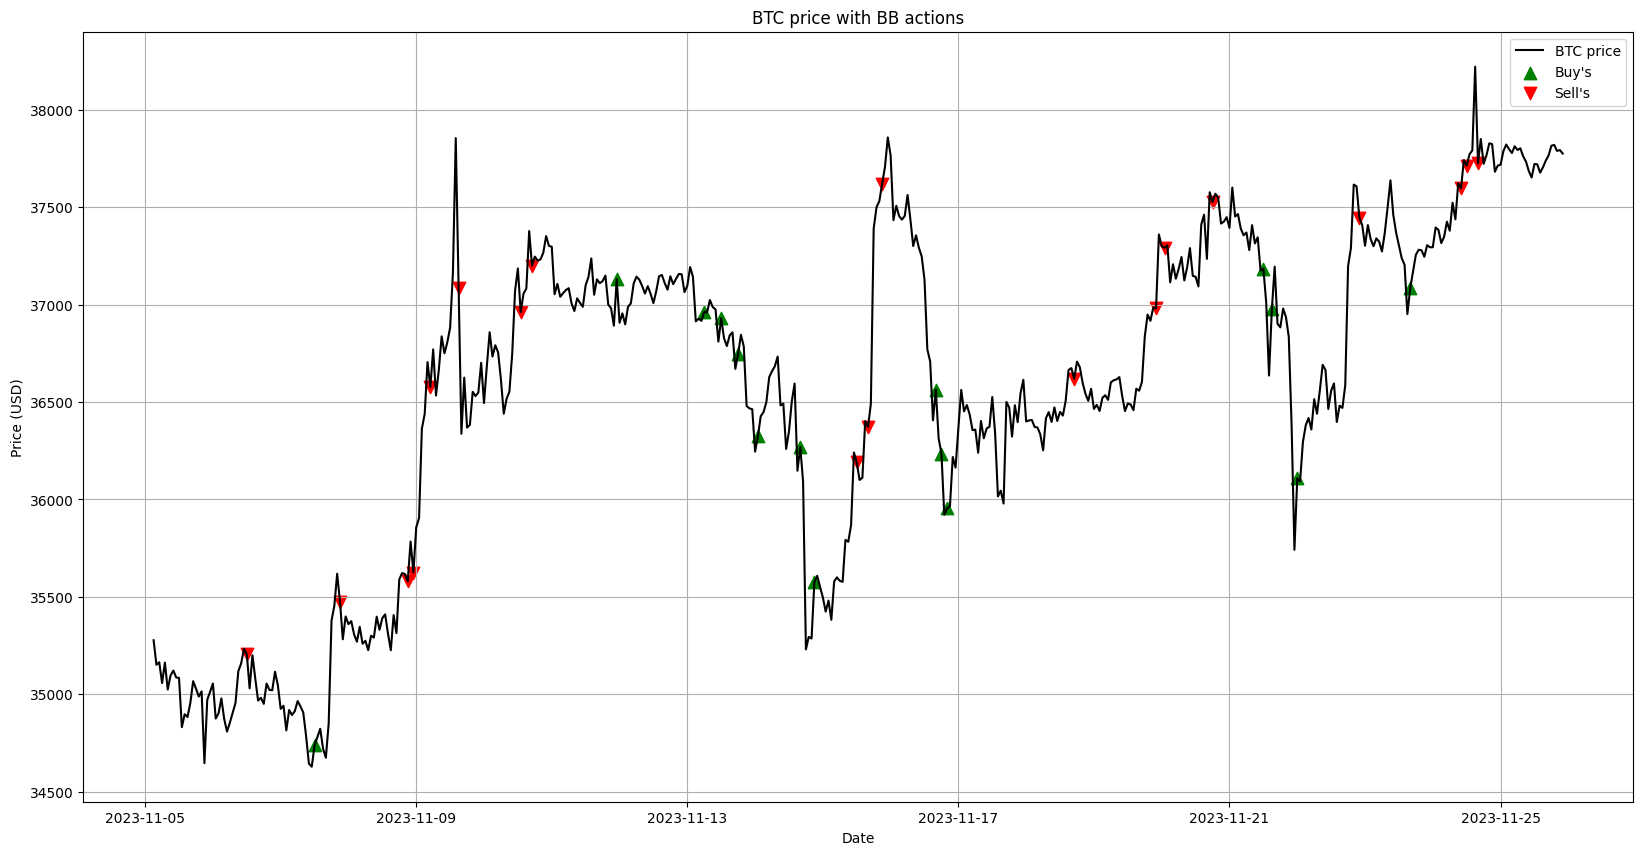

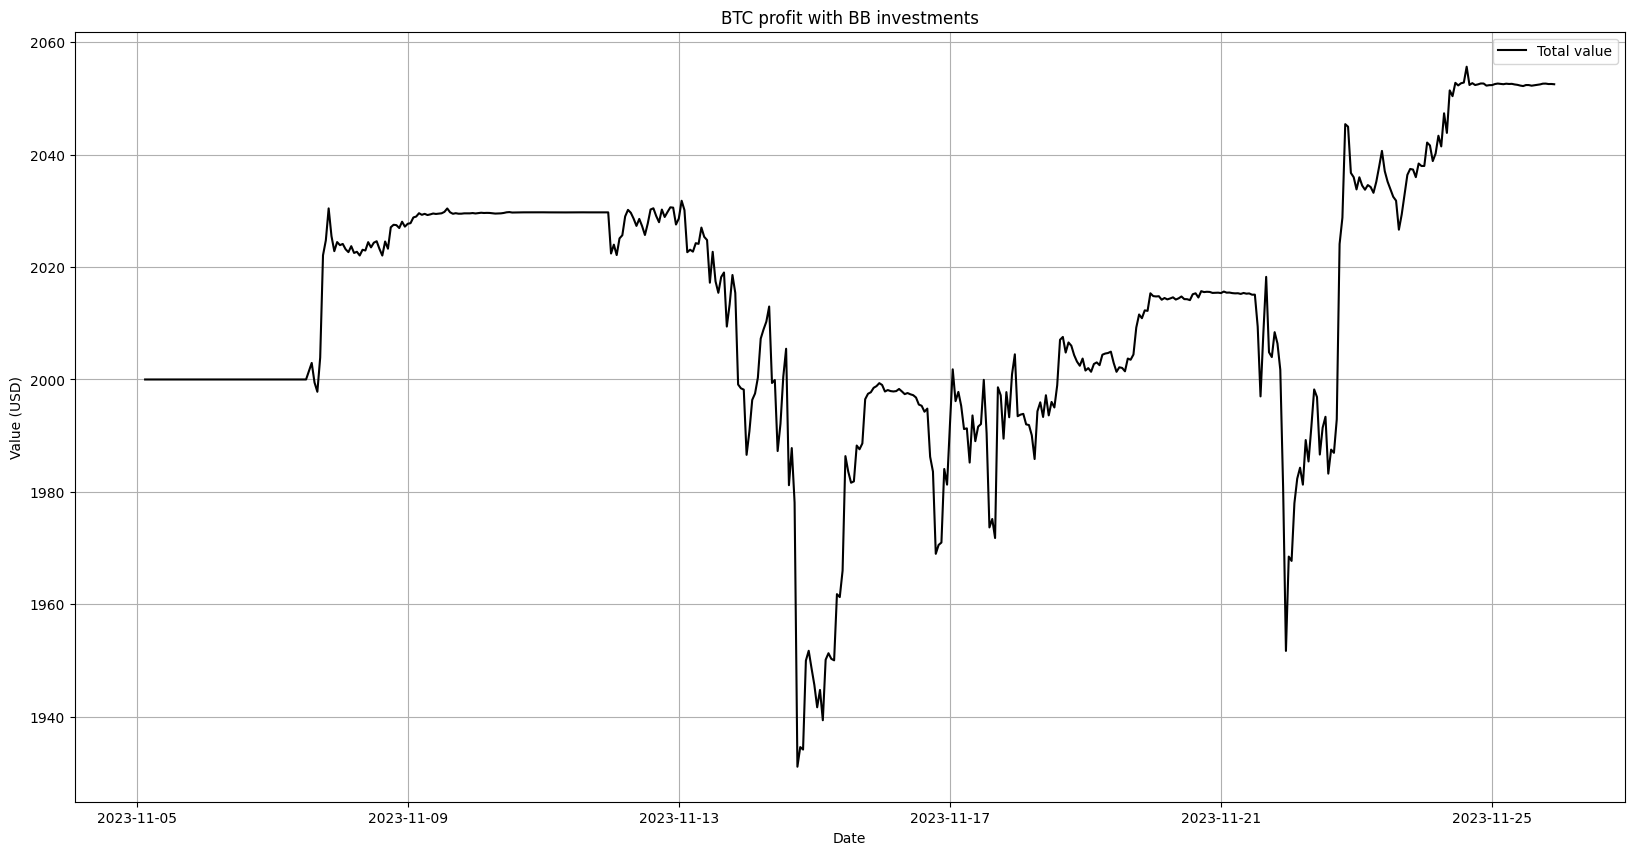

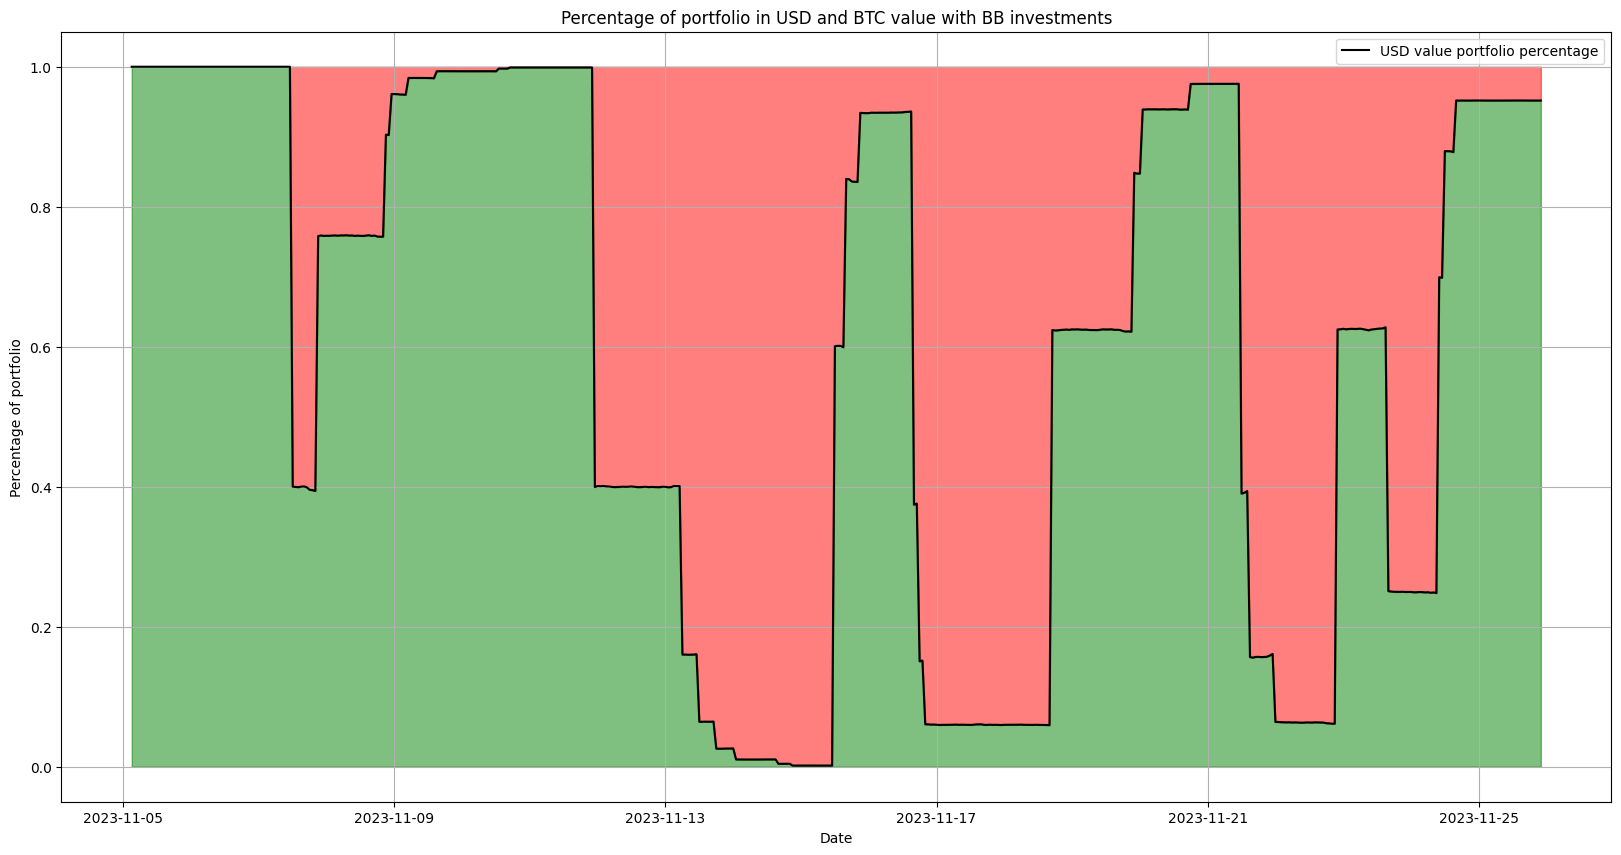

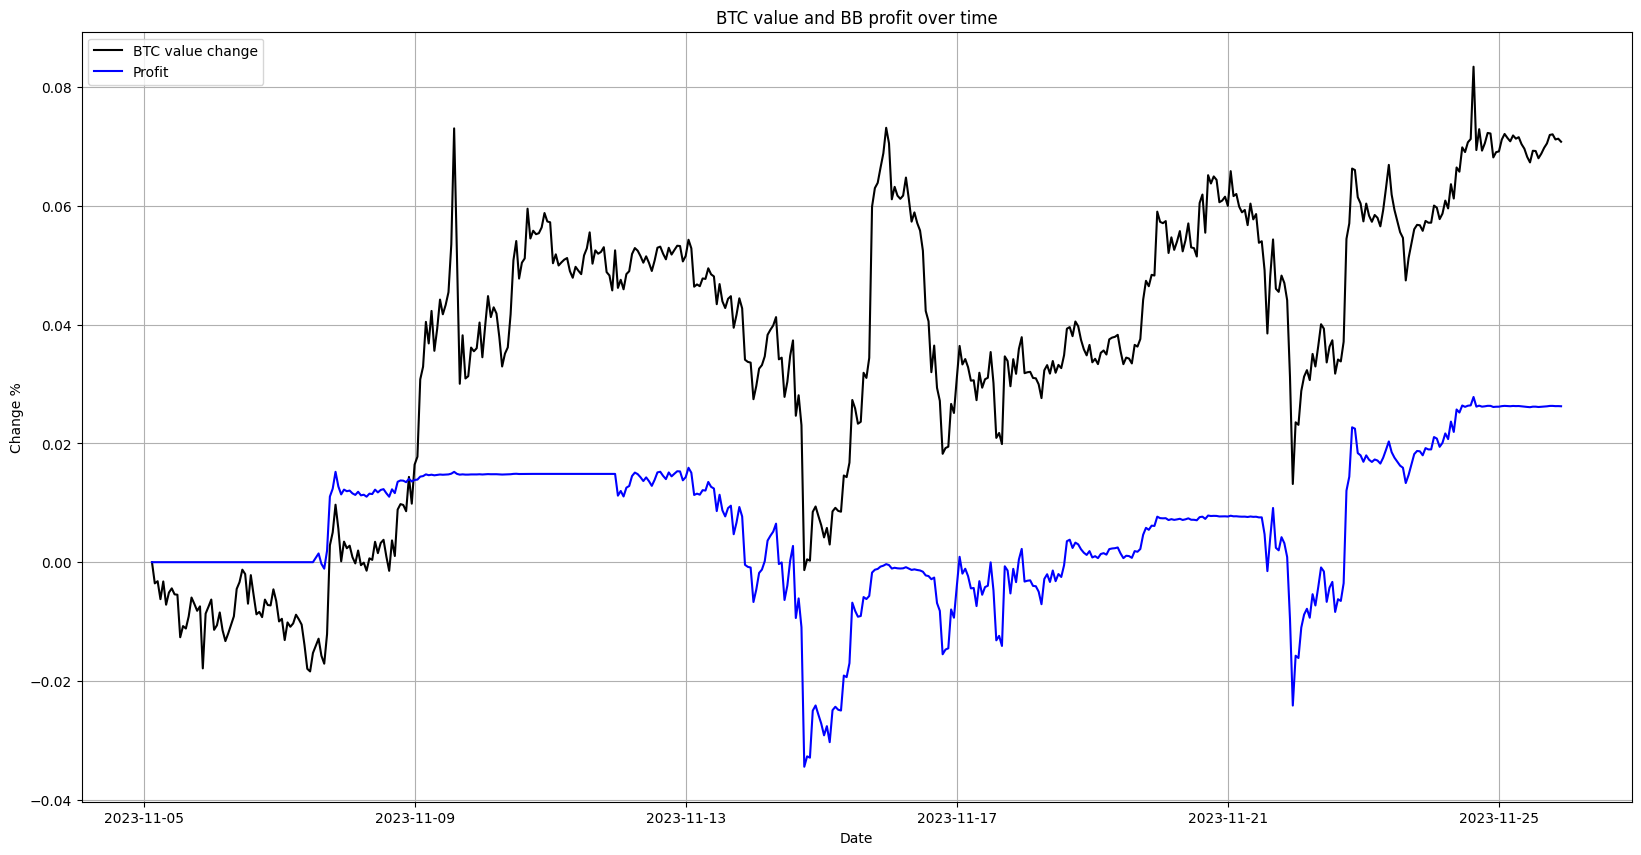

In [6]:
# BB agent
from agents.basic.bollinger_bands import BbAgent

# bb_window = config["BB_window"]["value"]
# bb_std = config["BB_std"]["value"]

bb_window = 20
bb_std = 2

print("bb_window:", bb_window)
print("bb_std:", bb_std)

# TODO: use BO to find parameters that maximize returns
bb_agent = BbAgent(bb_window, bb_std)
bb_actions = bb_agent.act(coin_data)

# TODO: strat
# first, figure out if thats legal
# - buy *long* position when BUY signal, with take-profit at 1.1% or something
# - buy *short* position when SELL signal, with take-profit at 1.1% or something

stop_loss = 0.2
portfolio_allocation = 0.6
assets_allocation = 0.6

# TODO: fix
bb_investments = SimpleStopLossInvestor(portfolio_size, stop_loss, portfolio_allocation, assets_allocation).get_investments(coin_data, bb_actions)

# plot BB actions
plot_actions(coin_data, bb_actions, "BTC", "BB")
plot_profit(coin_data, bb_investments, "BTC", "BB")

macd_fast: 12
macd_slow: 26
macd_signal: 9


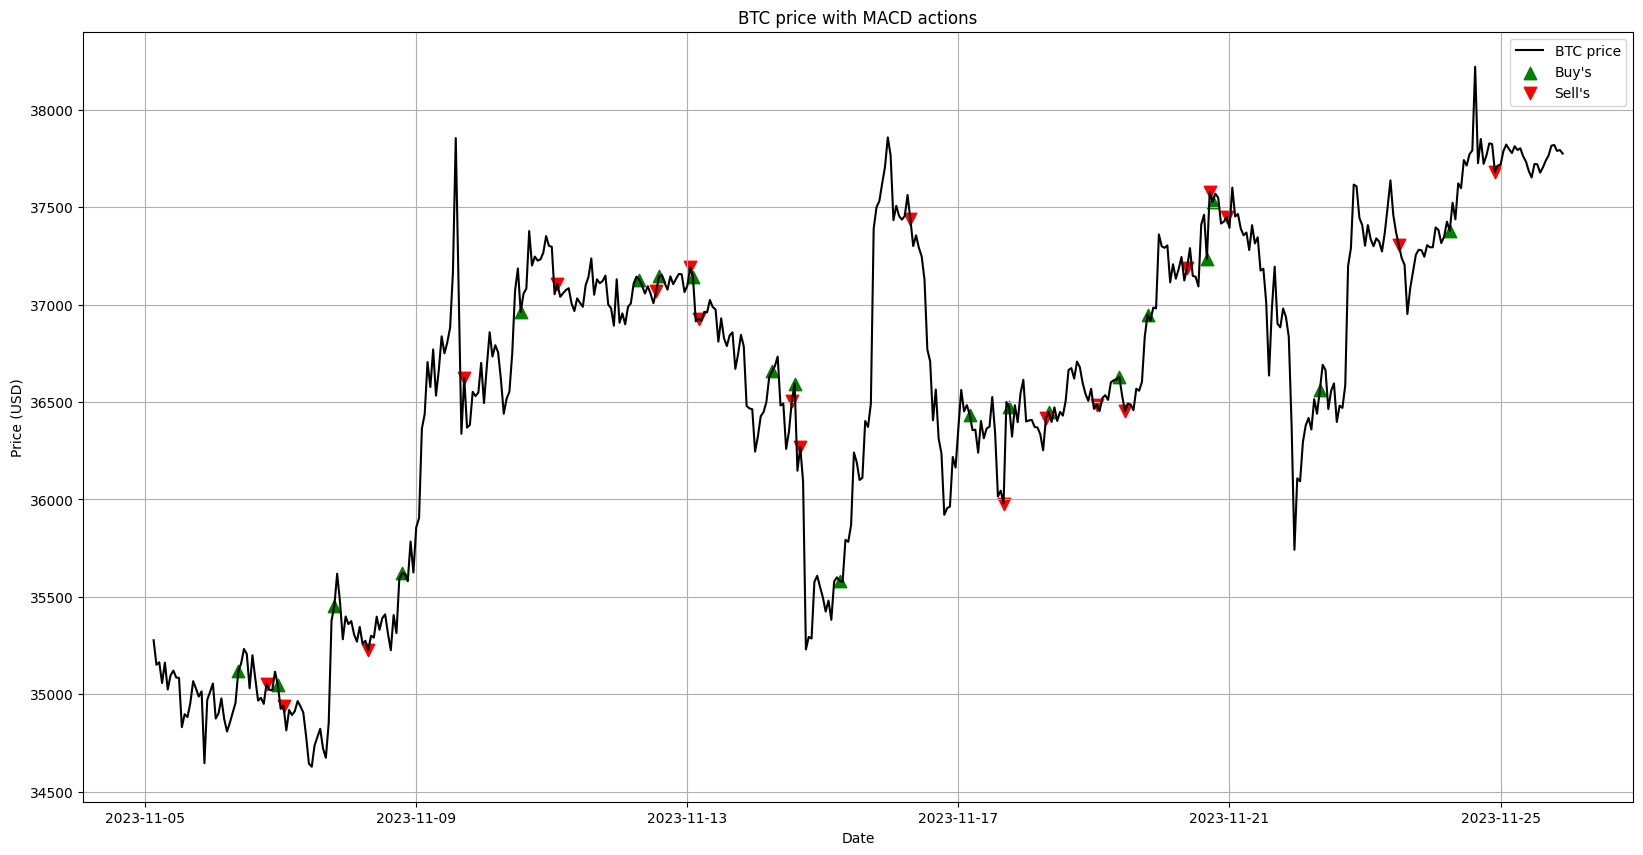

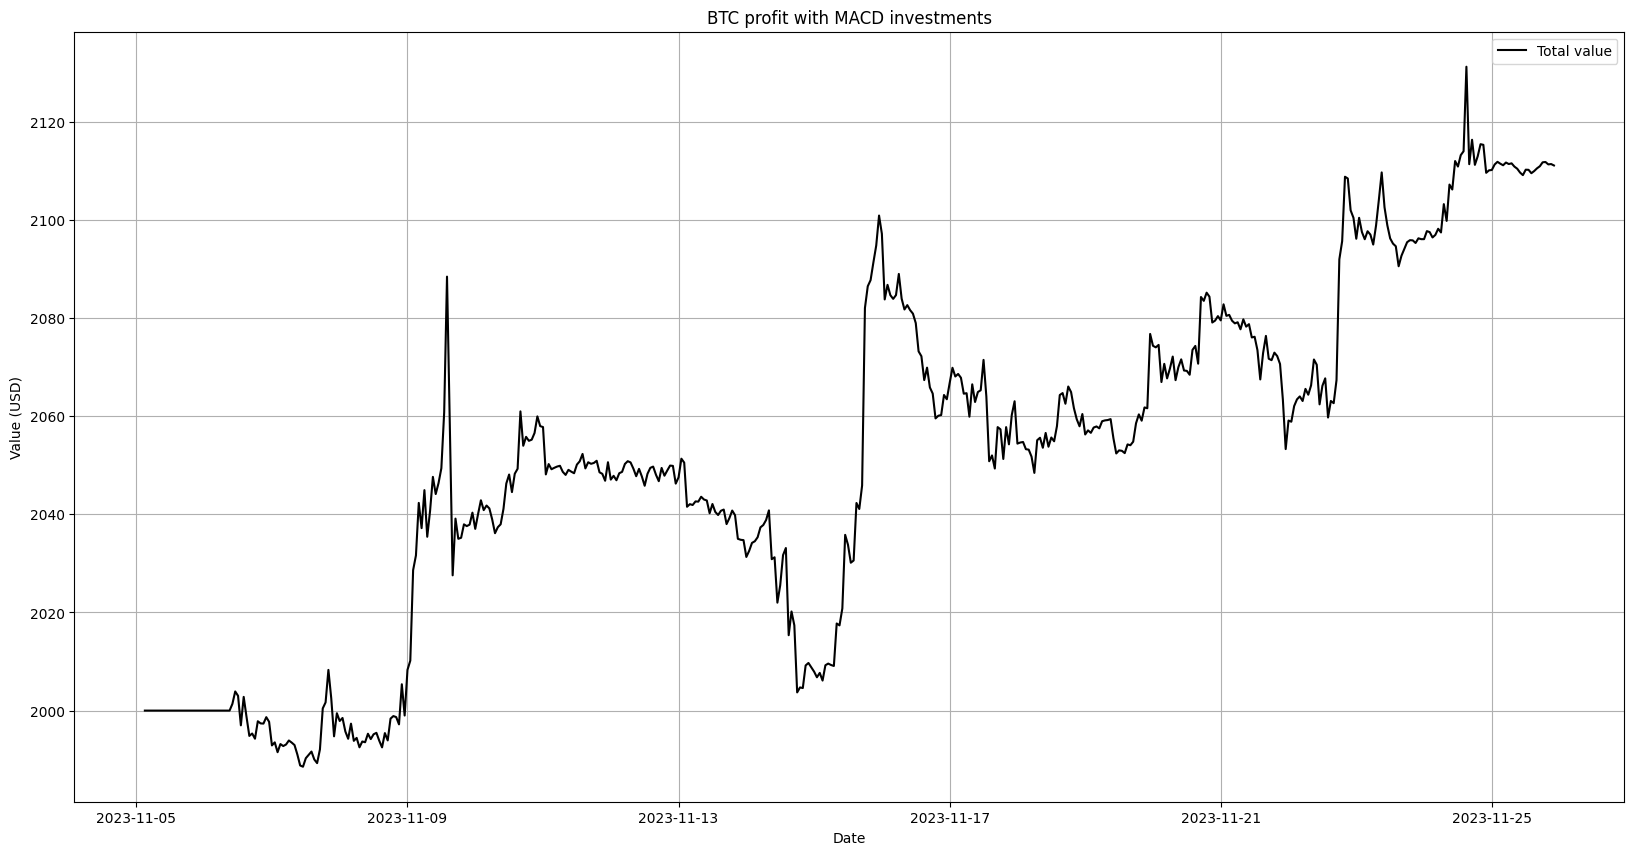

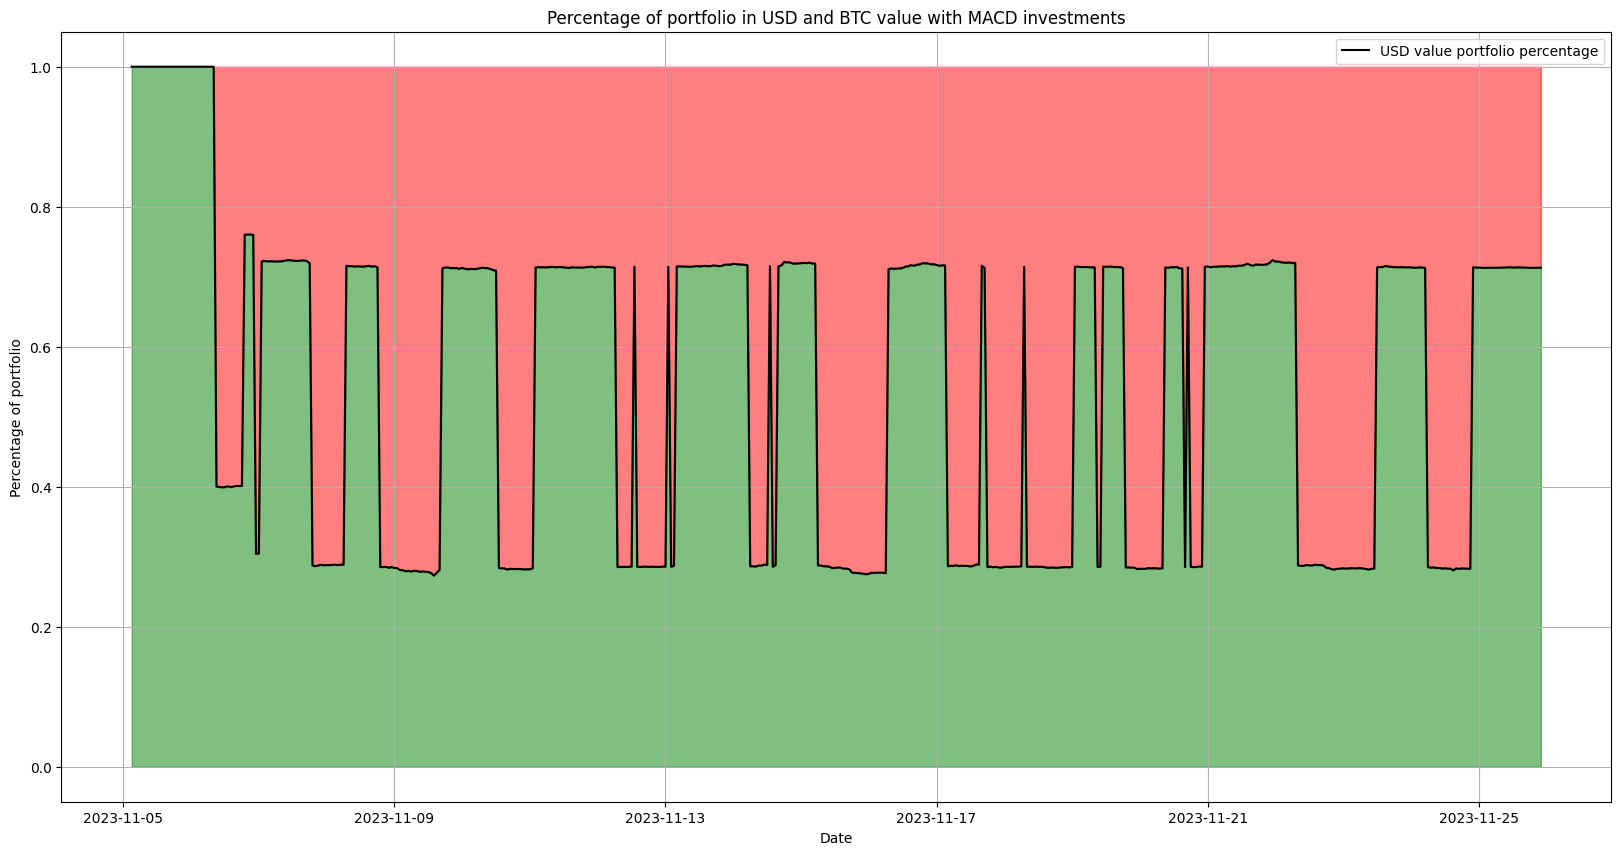

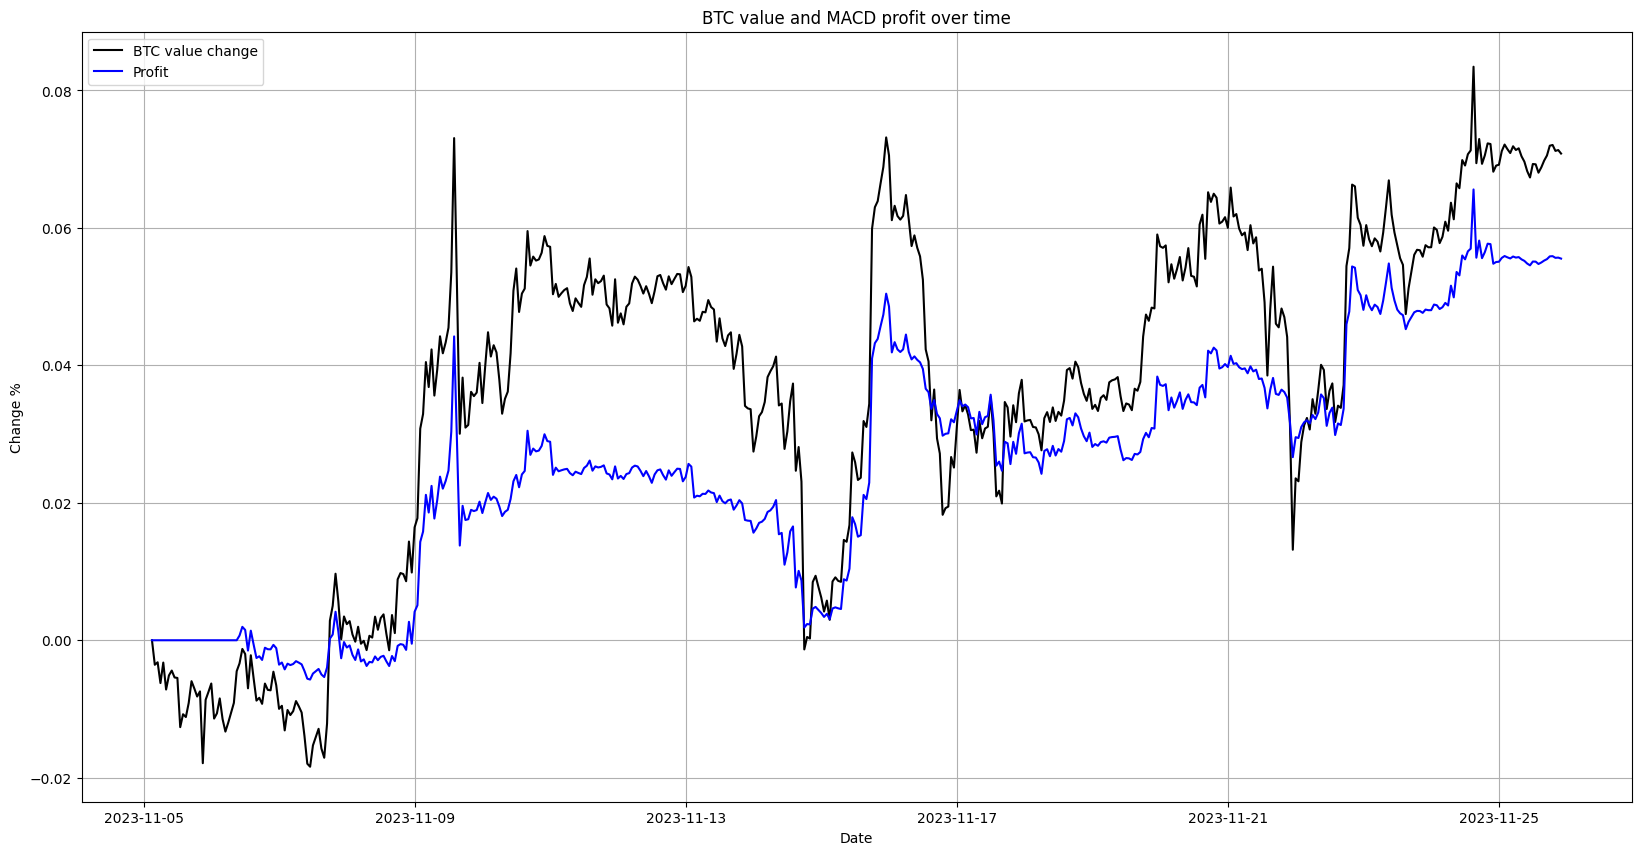

In [7]:
# implement MACD agent
from agents.basic.moving_average_convergence_divergence import MacdAgent

# TODO: MACD works better with margin investment
# TODO: combine it with some other indicator that figures out sideways market

# macd_fast = config["MACD_fast"]["value"]
# macd_slow = config["MACD_slow"]["value"]
# macd_signal = config["MACD_signal"]["value"]

macd_fast = 12
macd_slow = 26
macd_signal = 9

print("macd_fast:", macd_fast)
print("macd_slow:", macd_slow)
print("macd_signal:", macd_signal)

stop_loss = 0.1
portfolio_allocation = 0.6
assets_allocation = 0.6

macd_agent = MacdAgent(macd_fast, macd_slow, macd_signal)
macd_actions = macd_agent.act(coin_data)

macd_investments = SimpleStopLossInvestor(portfolio_size, stop_loss, portfolio_allocation, assets_allocation).get_investments(coin_data, macd_actions)

# plot MACD actions
plot_actions(coin_data, macd_actions, "BTC", "MACD")
plot_profit(coin_data, macd_investments, "BTC", "MACD")

rsi_window: 14
rsi_upper: 70
rsi_lower: 30


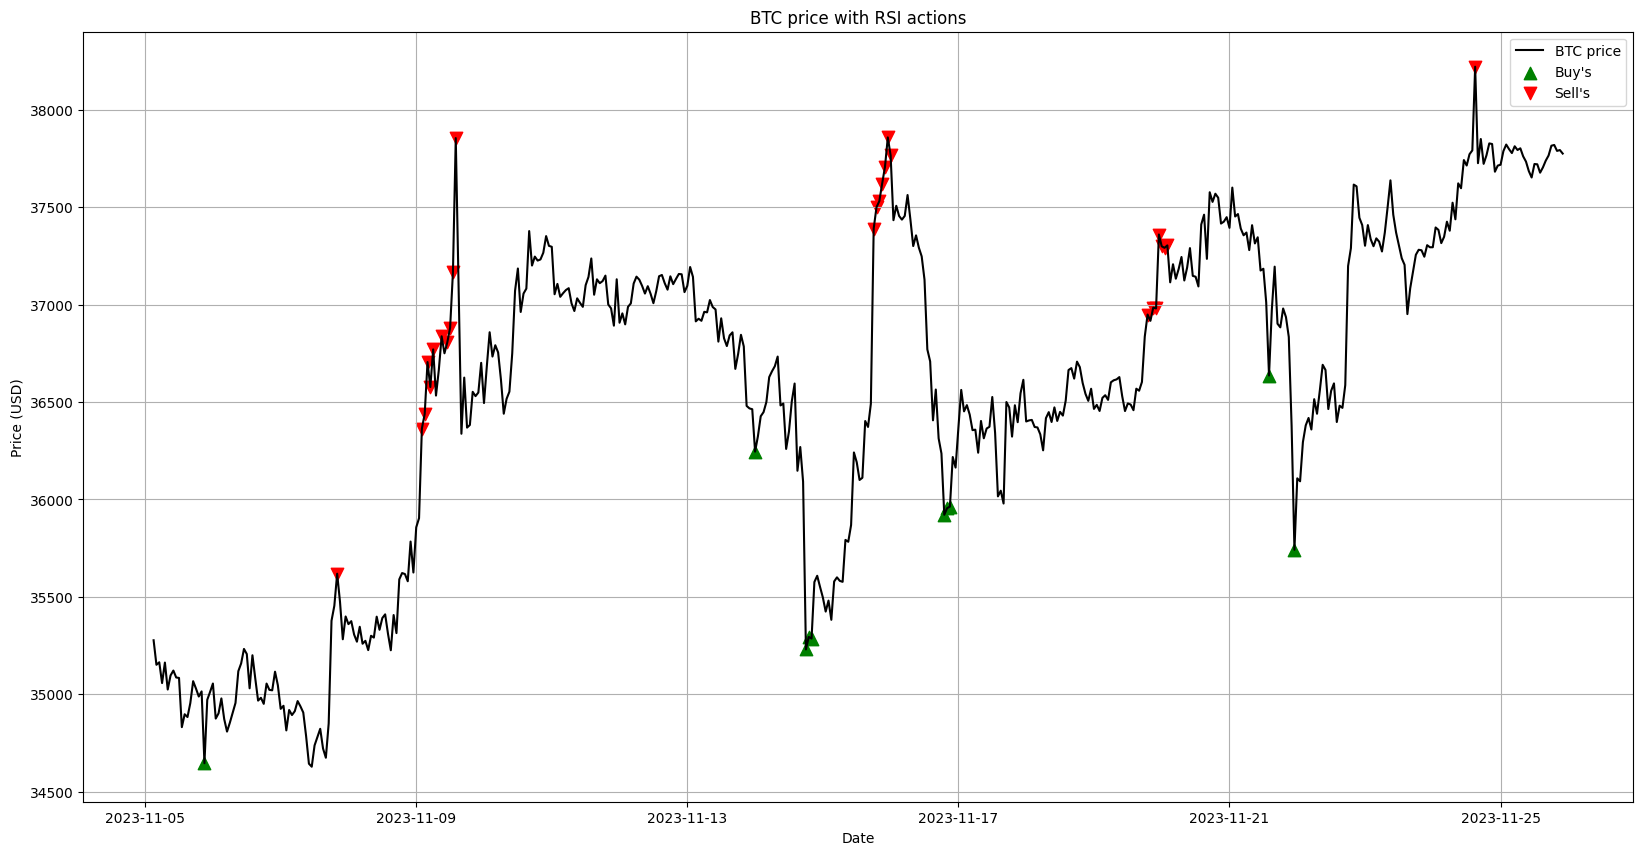

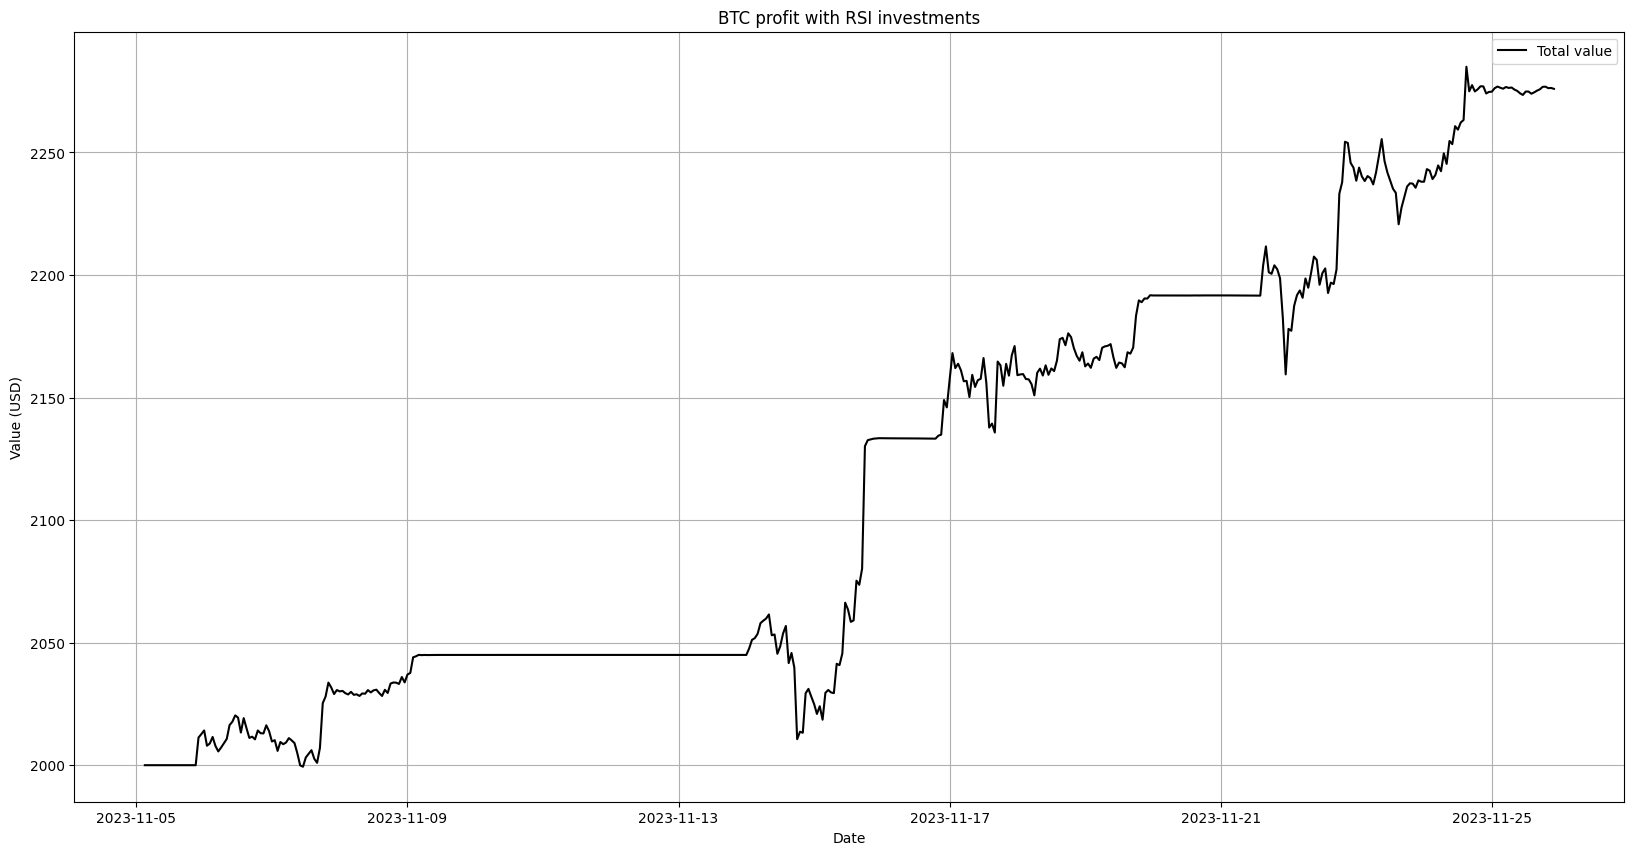

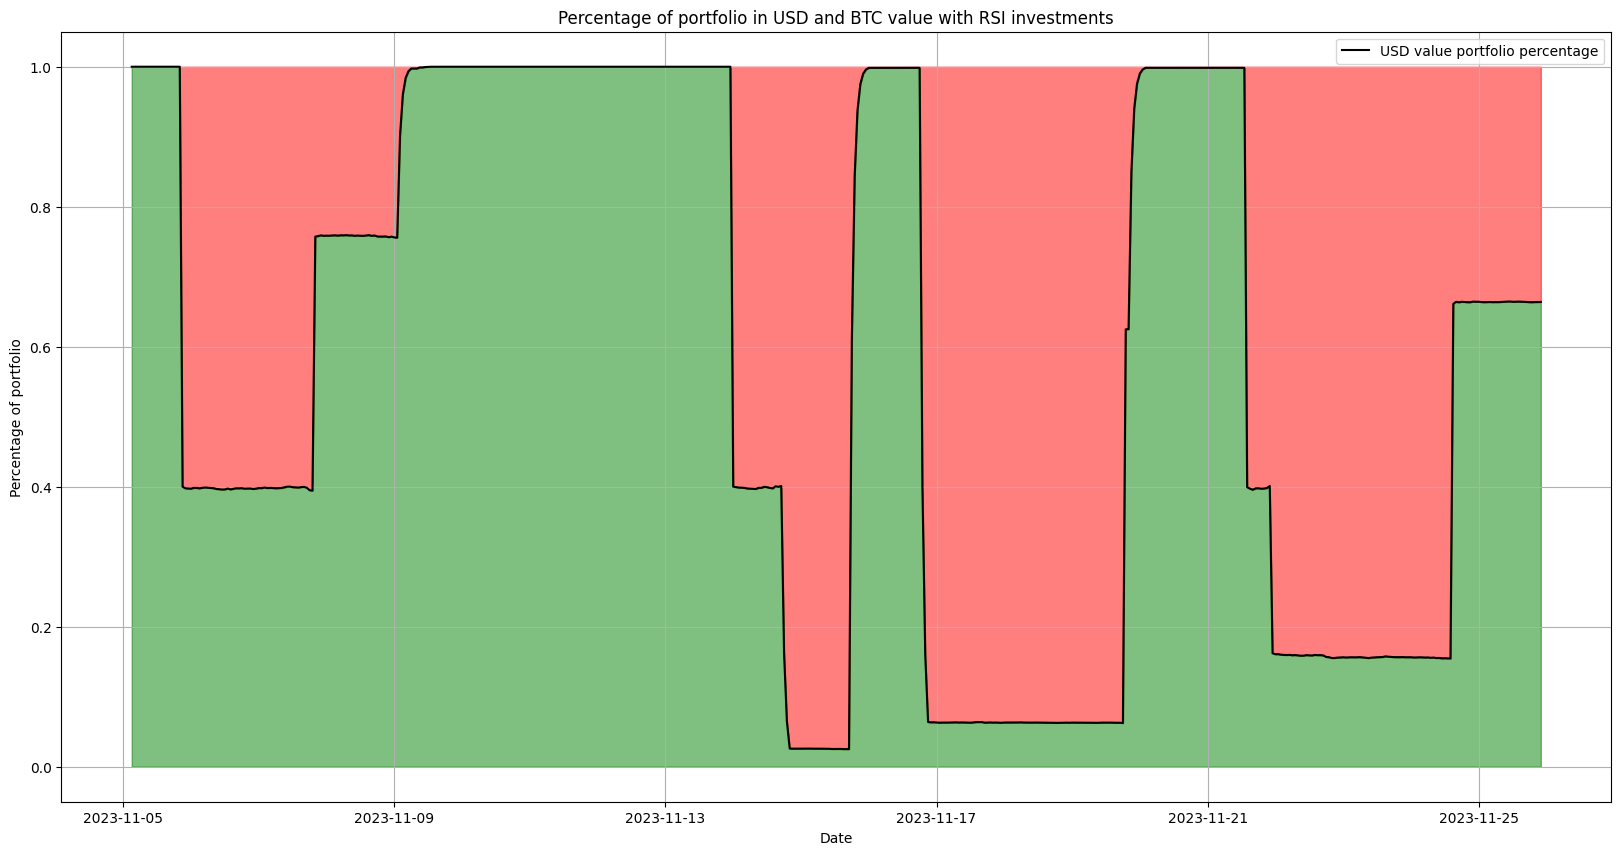

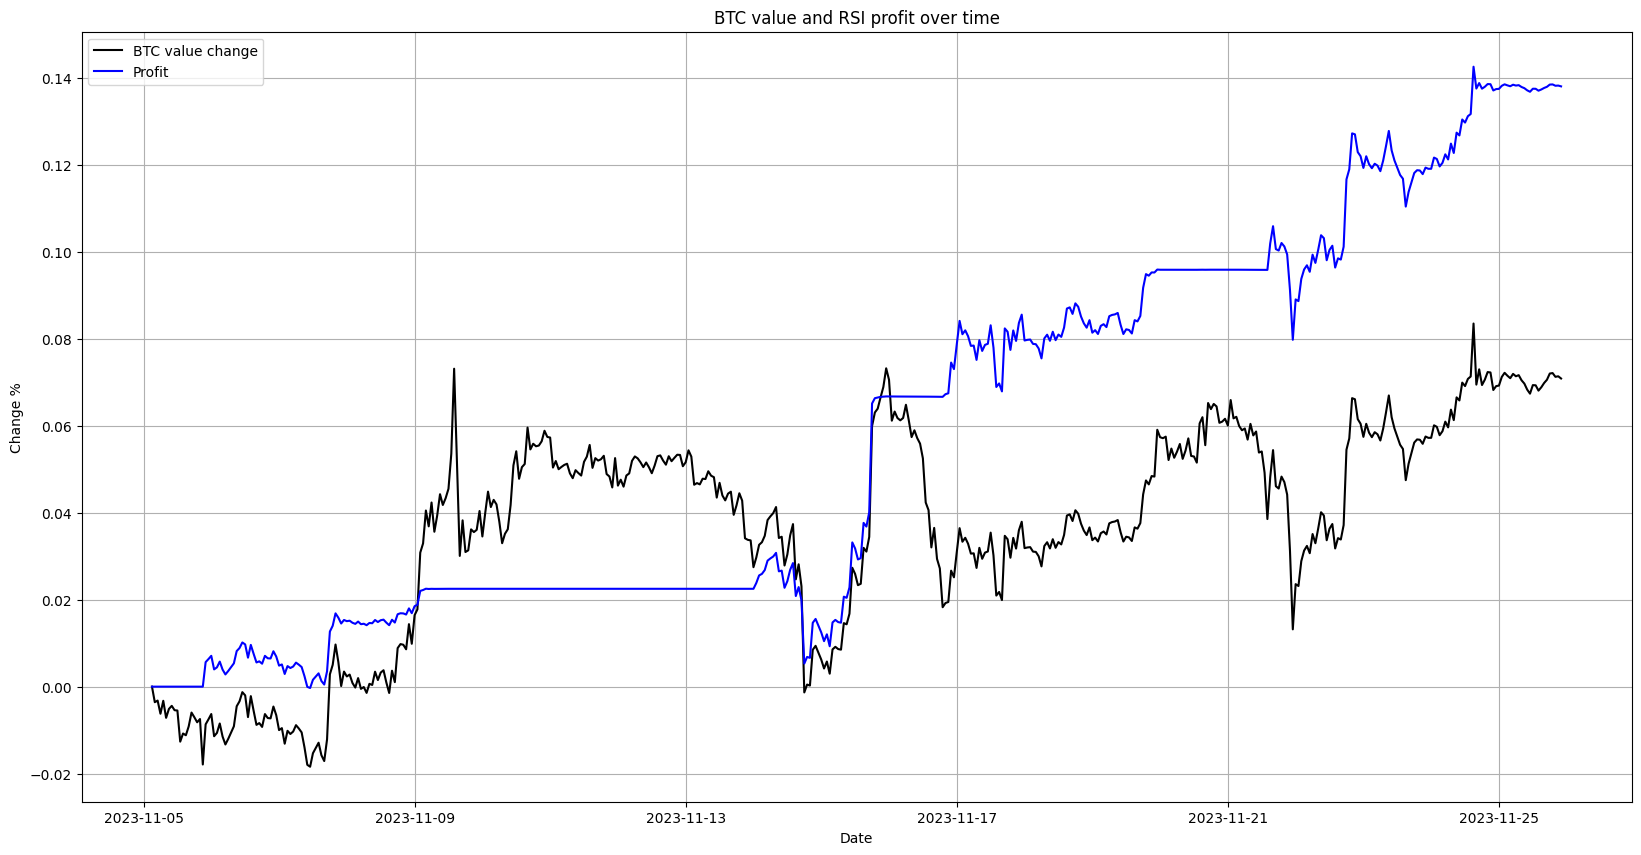

In [8]:
# implement RSI agent
from agents.basic.relative_strength_index import RsiAgent

# rsi_window = config["RSI_window"]["value"]
# rsi_upper = config["RSI_upper"]["value"]
# rsi_lower = config["RSI_lower"]["value"]

rsi_window = 14
rsi_upper = 70
rsi_lower = 30

print("rsi_window:", rsi_window)
print("rsi_upper:", rsi_upper)
print("rsi_lower:", rsi_lower)

stop_loss = 0.1
portfolio_allocation = 0.6
assets_allocation = 0.6

rsi_agent = RsiAgent(rsi_window, rsi_lower, rsi_upper)
rsi_actions = rsi_agent.act(coin_data)

rsi_investments = SimpleStopLossInvestor(portfolio_size, stop_loss, portfolio_allocation, assets_allocation).get_investments(coin_data, rsi_actions)

# plot RSI actions
plot_actions(coin_data, rsi_actions, "BTC", "RSI")
plot_profit(coin_data, rsi_investments, "BTC", "RSI")

dmac_fast: 12
dmac_slow: 26
dmac_signal: 9
dmac_rsi_window: 14
dmac_rsi_upper: 70
dmac_rsi_lower: 30


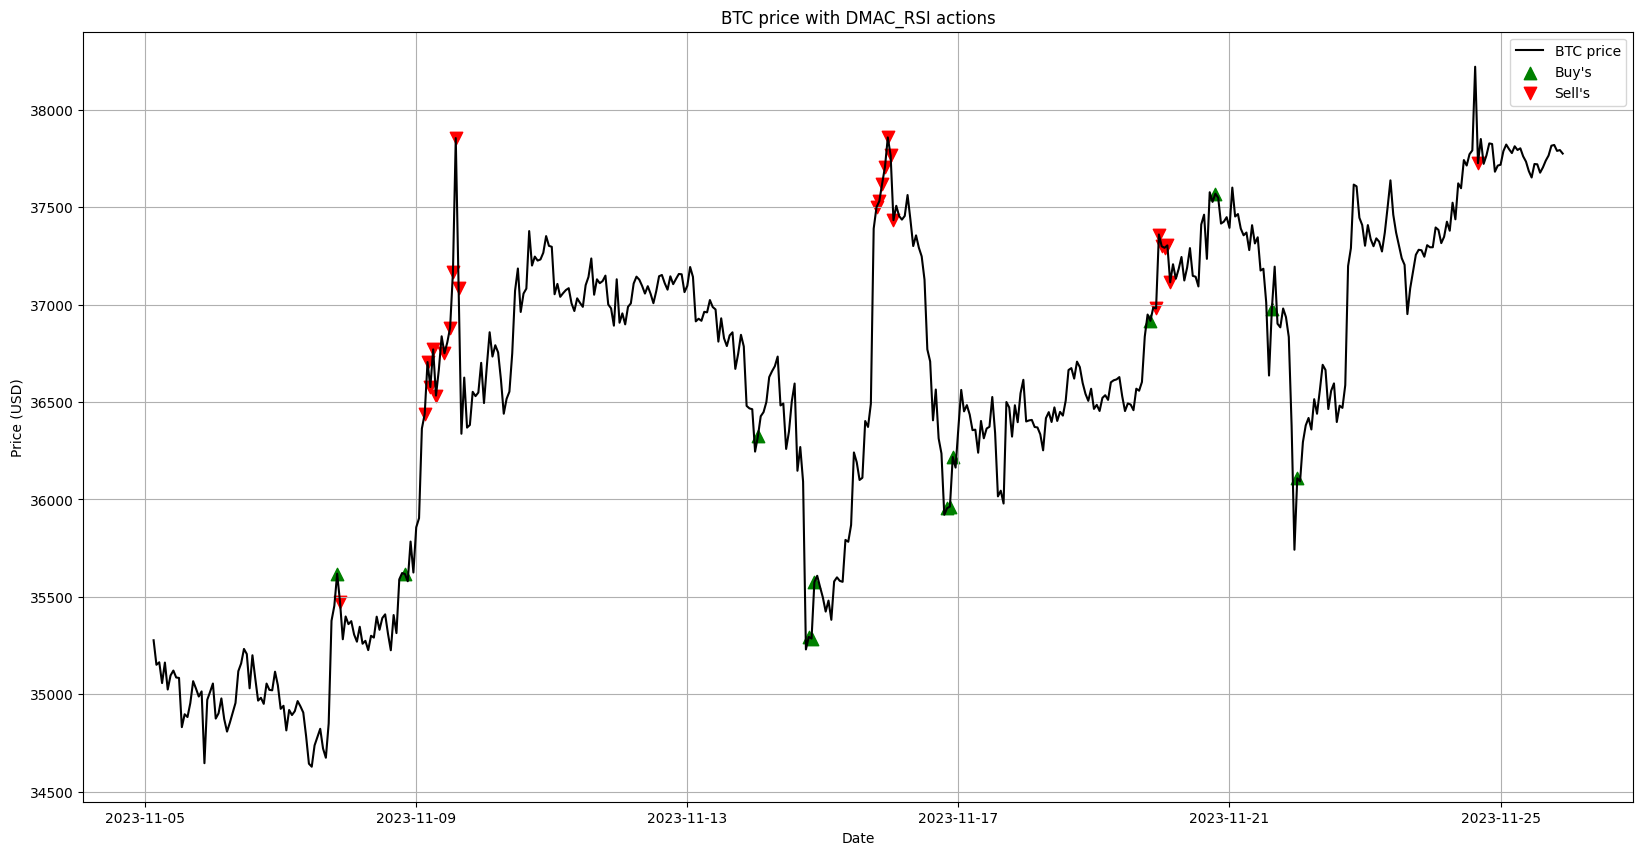

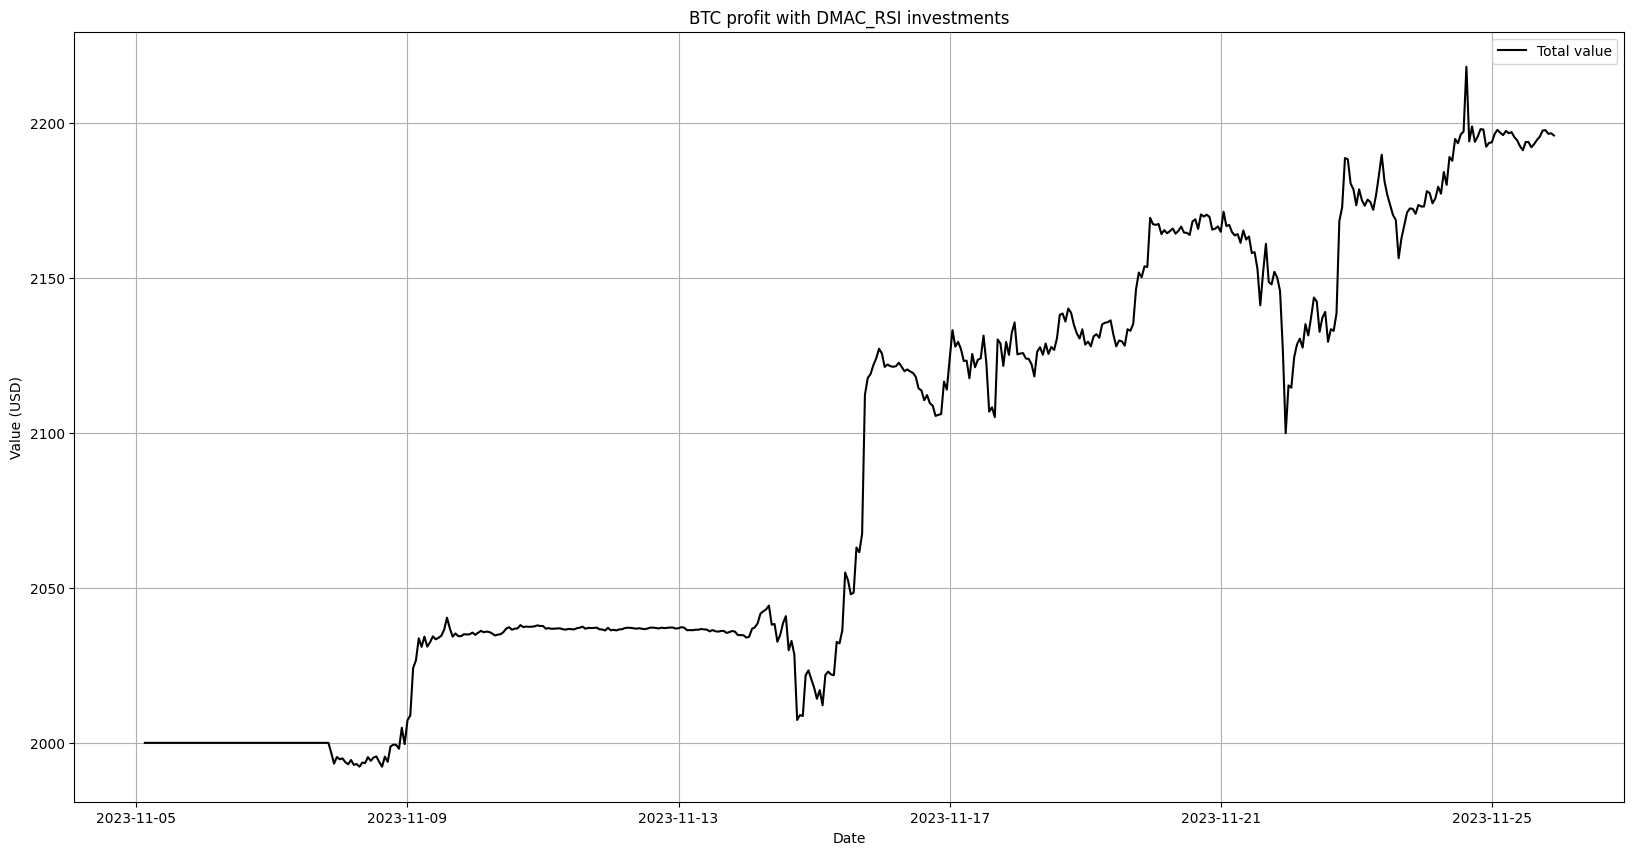

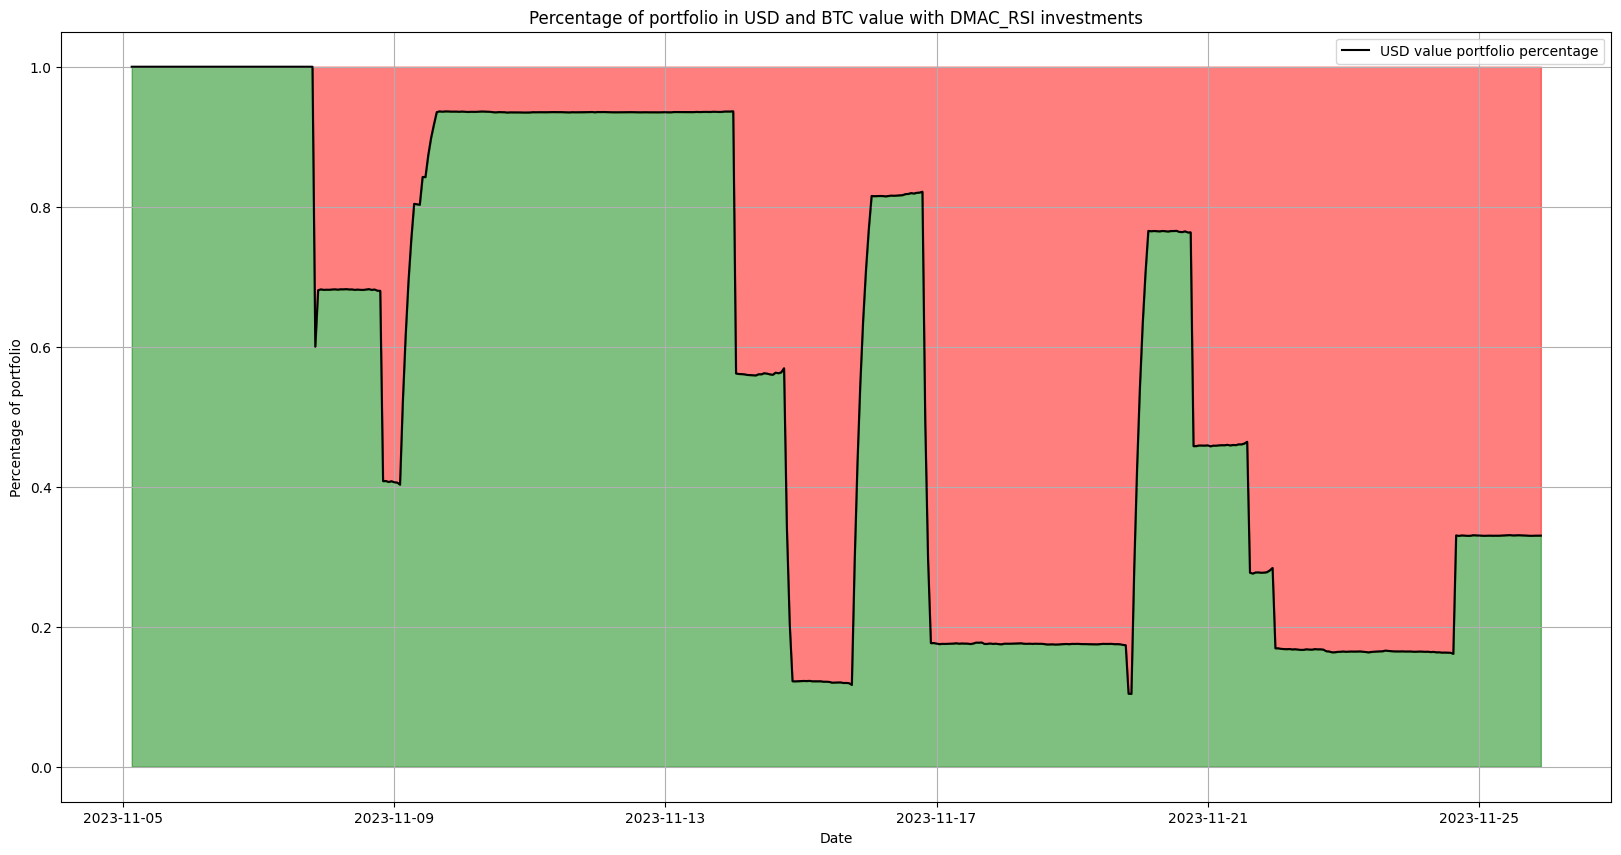

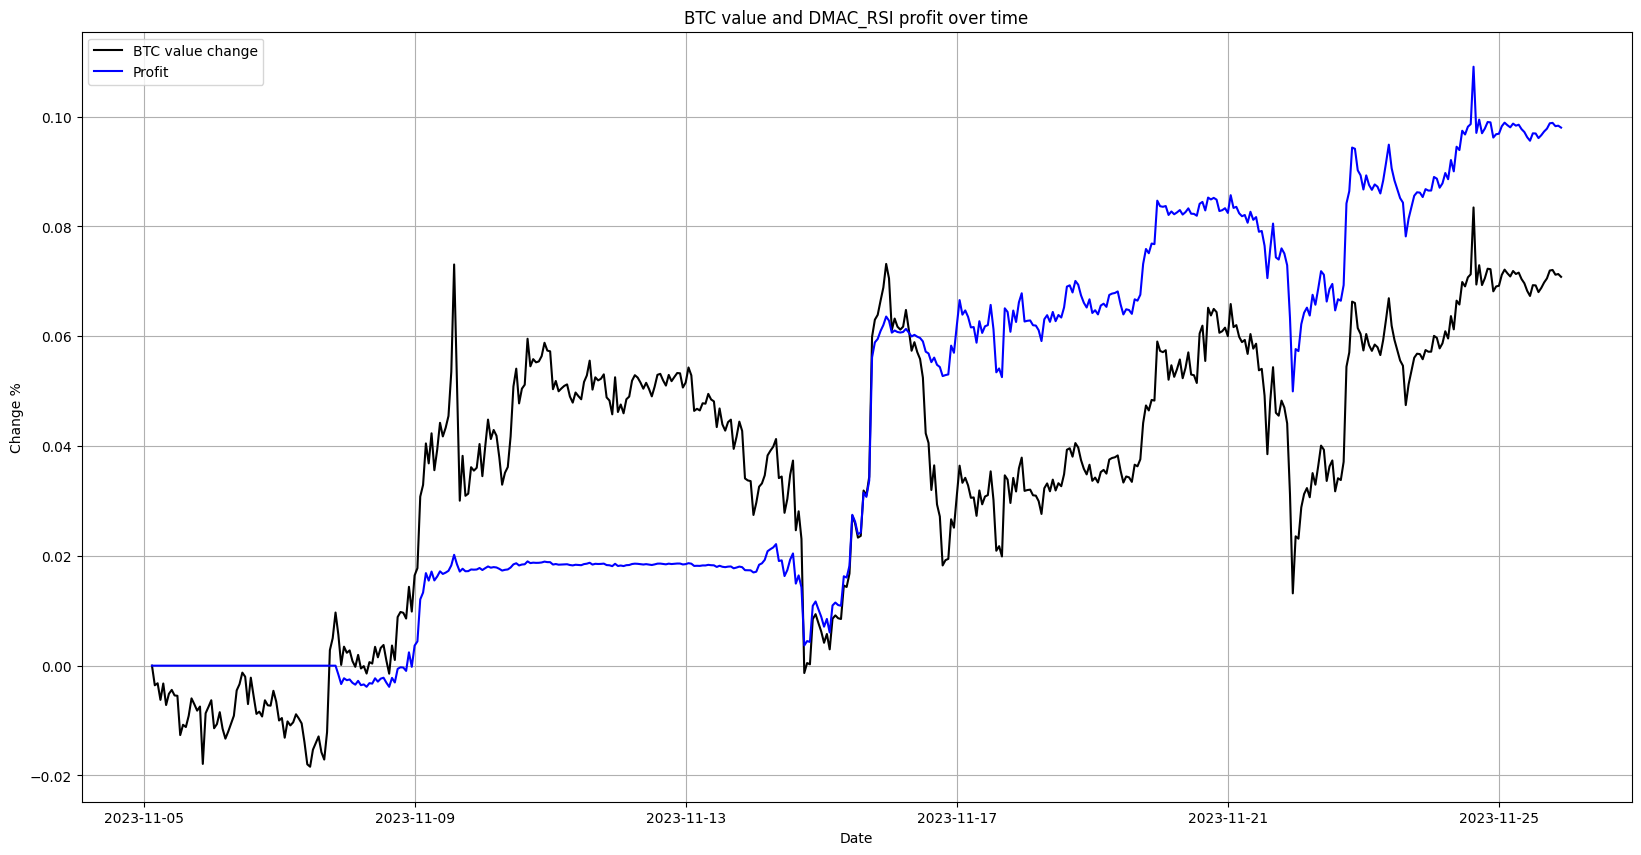

In [9]:
# implement dual moving average crossover + RSI agent
from agents.strategies.macd_rsi import MacdRsiAgent

# dmac_fast = config["DMAC_fast"]["value"]
# dmac_slow = config["DMAC_slow"]["value"]
# dmac_signal = config["DMAC_signal"]["value"]
# dmac_rsi_window = config["DMAC_RSI_window"]["value"]
# dmac_rsi_upper = config["DMAC_RSI_upper"]["value"]
# dmac_rsi_lower = config["DMAC_RSI_lower"]["value"]

dmac_fast = 12
dmac_slow = 26
dmac_signal = 9
dmac_rsi_window = 14
dmac_rsi_lower = 30
dmac_rsi_upper = 70

print("dmac_fast:", dmac_fast)
print("dmac_slow:", dmac_slow)
print("dmac_signal:", dmac_signal)
print("dmac_rsi_window:", dmac_rsi_window)
print("dmac_rsi_upper:", dmac_rsi_upper)
print("dmac_rsi_lower:", dmac_rsi_lower)

stop_loss = 0.11
portfolio_allocation = 0.4
assets_allocation = 0.2

macd_rsi_agent = MacdRsiAgent(dmac_fast, dmac_slow, dmac_signal, dmac_rsi_window, dmac_rsi_lower, dmac_rsi_upper)
macd_rsi_actions = macd_rsi_agent.act(coin_data)

macd_rsi_investments = SimpleStopLossInvestor(portfolio_size, stop_loss, portfolio_allocation, assets_allocation).get_investments(coin_data, macd_rsi_actions)

# plot DMAC_RSI actions
plot_actions(coin_data, macd_rsi_actions, "BTC", "DMAC_RSI")
plot_profit(coin_data, macd_rsi_investments, "BTC", "DMAC_RSI")


sma_rsi_fast: 12
sma_rsi_slow: 26
sma_rsi_window: 14
sma_rsi_upper: 65
sma_rsi_lower: 35


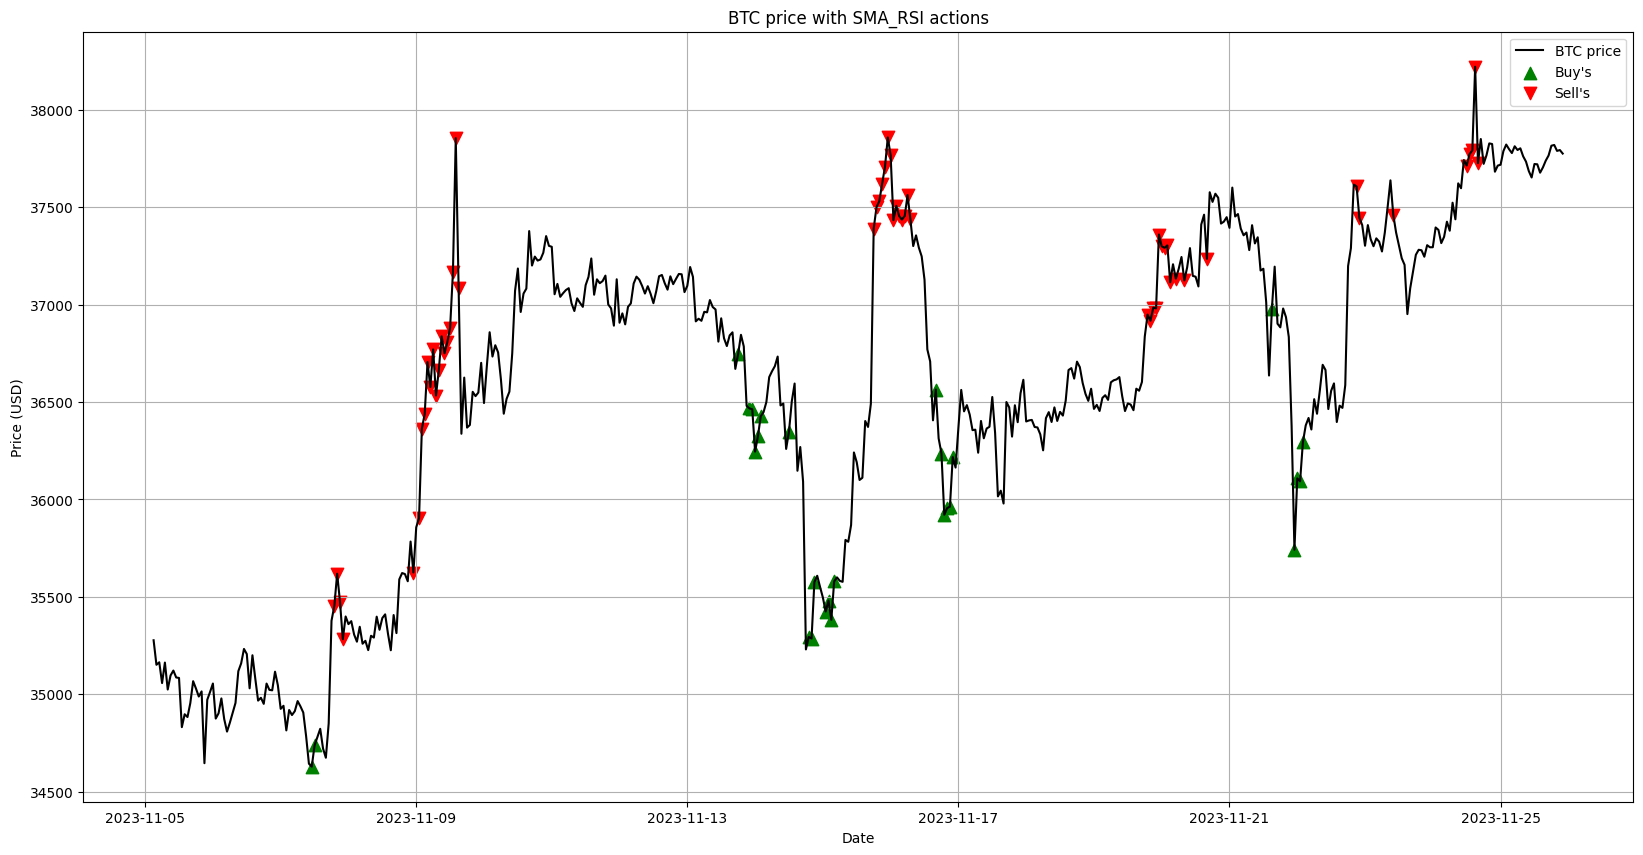

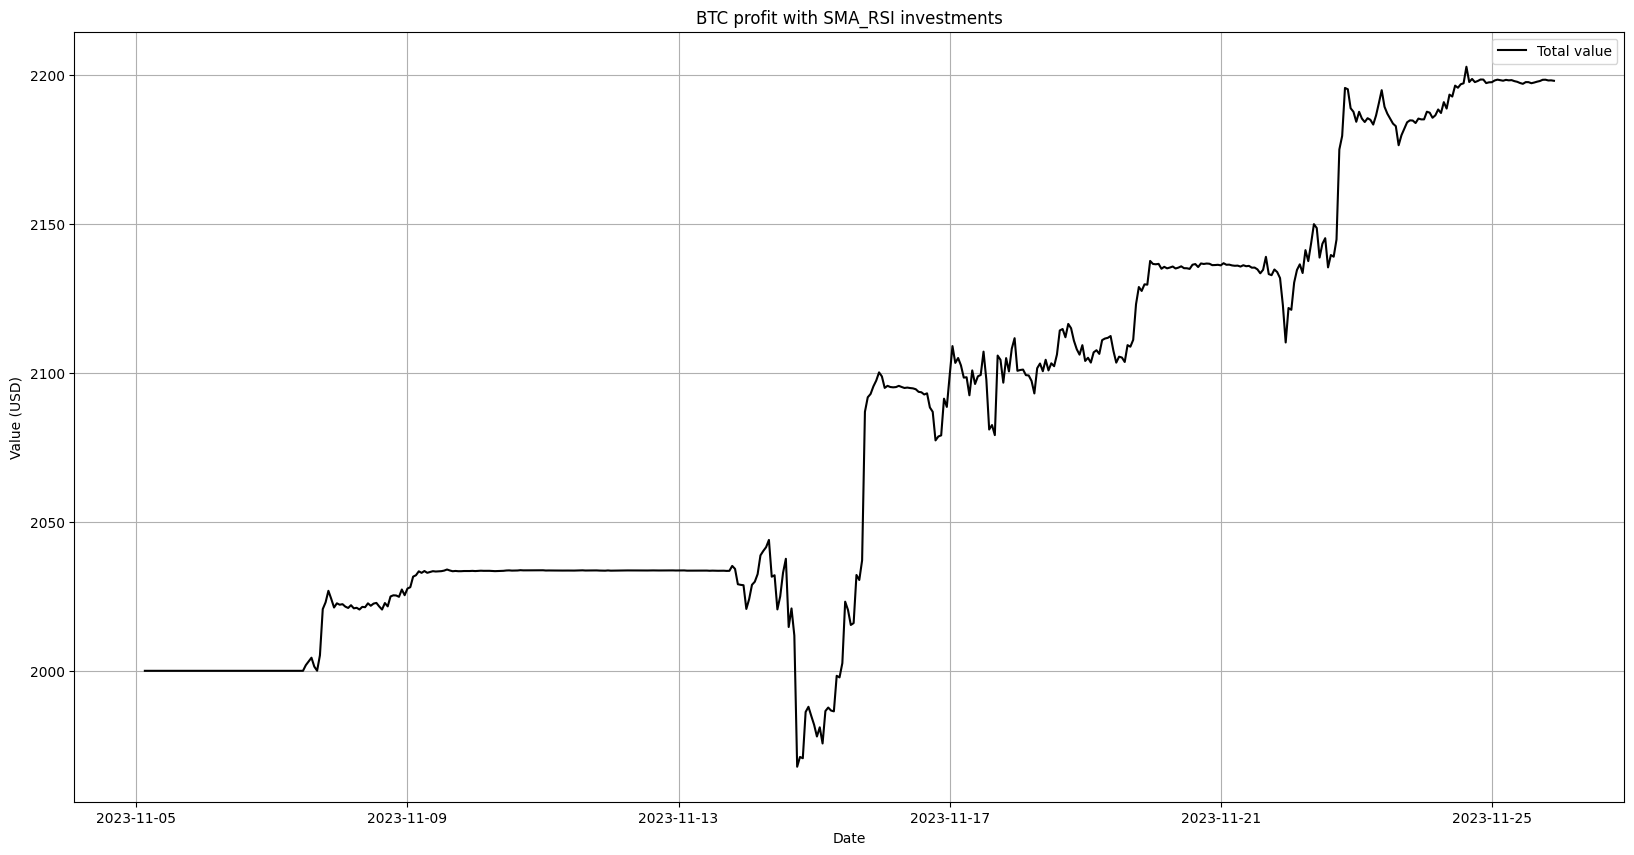

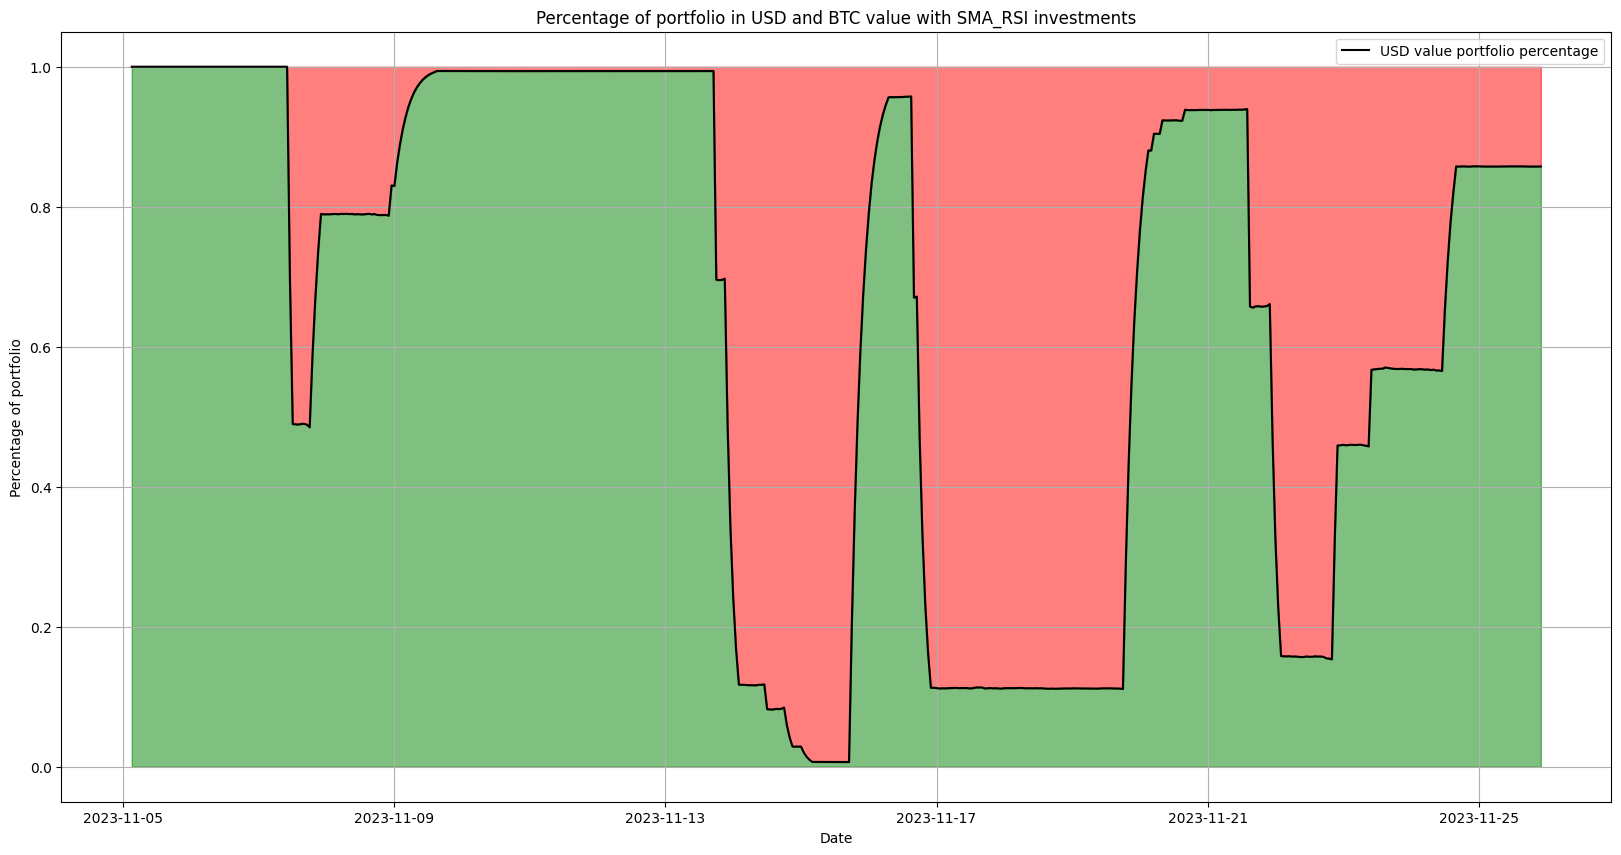

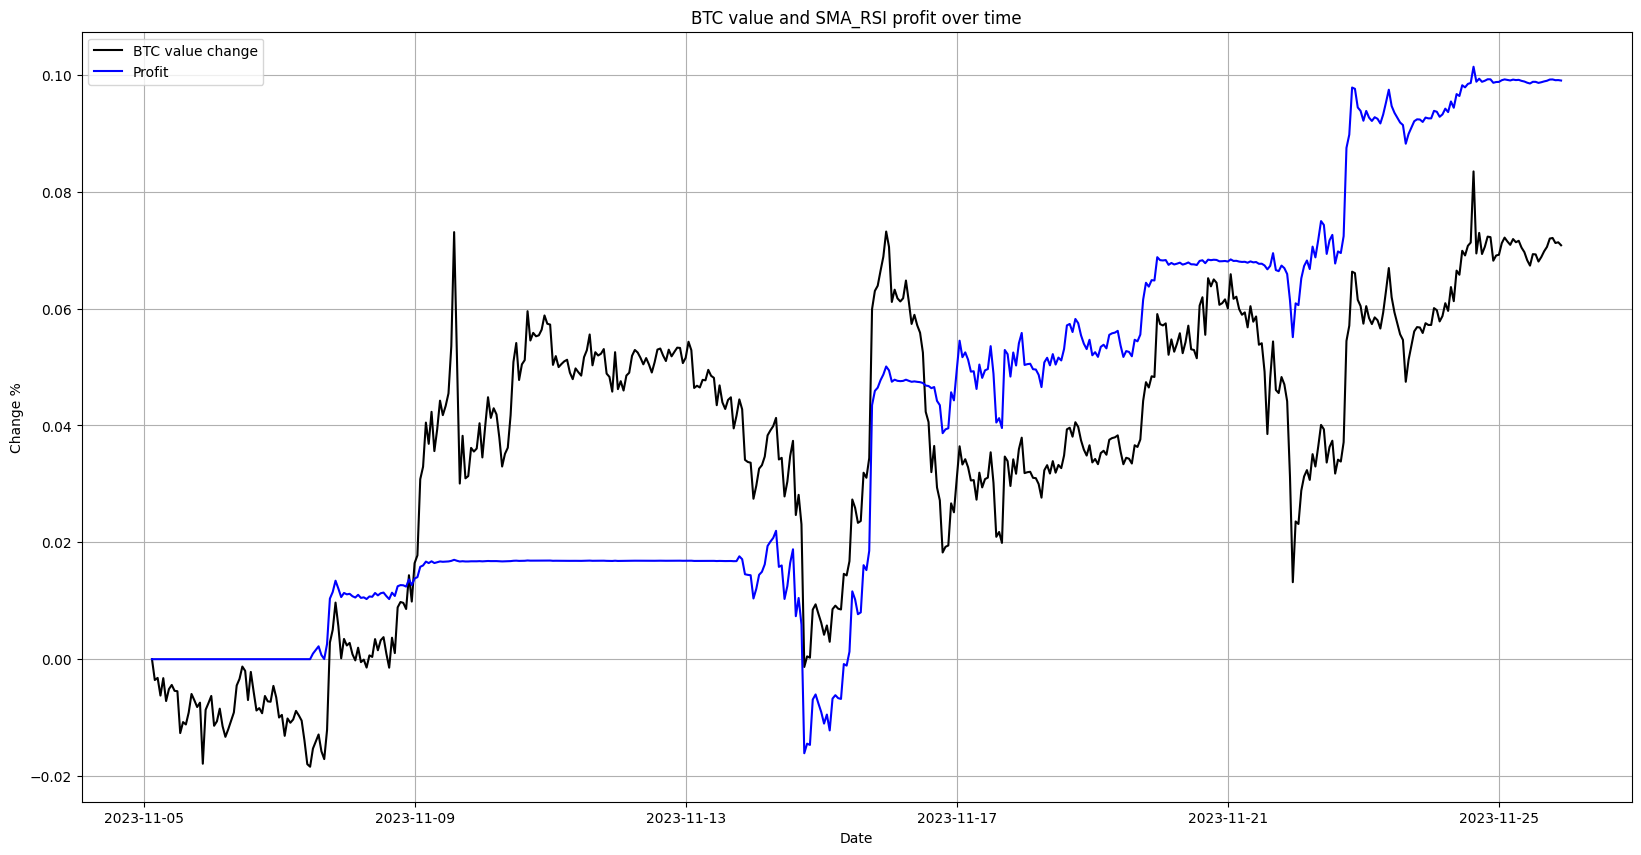

In [11]:
# implement SMA_RSI agent
from agents.strategies.dmac_rsi import DmacRsiAgent

# sma__rsi_fast = config["SMA_fast"]["value"]
# sma__rsi_slow = config["SMA_slow"]["value"]
# sma_rsi_window = config["SMA_RSI_window"]["value"]
# sma_rsi_upper = config["SMA_RSI_upper"]["value"]
# sma_rsi_lower = config["SMA_RSI_lower"]["value"]

sma_rsi_fast = 12
sma_rsi_slow = 26
sma_rsi_window = 14
sma_rsi_lower = 35
sma_rsi_upper = 65

print("sma_rsi_fast:", sma_rsi_fast)
print("sma_rsi_slow:", sma_rsi_slow)
print("sma_rsi_window:", sma_rsi_window)
print("sma_rsi_upper:", sma_rsi_upper)
print("sma_rsi_lower:", sma_rsi_lower)

stop_loss = 0.11
portfolio_allocation = 0.3
assets_allocation = 0.2

dmac_rsi_agent = DmacRsiAgent(sma_rsi_fast, sma_rsi_slow, sma_rsi_window, sma_rsi_lower, sma_rsi_upper)
dmac_rsi_actions = dmac_rsi_agent.act(coin_data)

dmac_rsi_investments = SimpleStopLossInvestor(portfolio_size, stop_loss, portfolio_allocation, assets_allocation).get_investments(coin_data, dmac_rsi_actions)

# plot SMA_RSI actions
plot_actions(coin_data, dmac_rsi_actions, "BTC", "SMA_RSI")
plot_profit(coin_data, dmac_rsi_investments, "BTC", "SMA_RSI")
